<img src="IMG/banner_edit.jpg">

# 🧑‍🔧 Scraping Data Jobs with Python and Selenium

*Source: 🤖 [Data Jobs Webscraper](https://github.com/ColinB19/datajobswebscraper) Repo*

I've always been fascinated by the structure of data. My interest in physics during college led me to enjoy finding patterns and solving complex problems, which naturally steered me towards Data Science. As a Data Analyst, I love my job, but I'm eager to tackle more challenging problems and fully transition into Data Science.

With the abundance of resources online, breaking into Data Science can be overwhelming, especially with limited time. To focus my efforts, I decided to create a portfolio project analyzing Data Science, Analytics, and Engineering job postings scraped from the internet to identify key skills. This project aims to help me, and others, understand the most common requirements for these roles.

## This Project

This script will functionalize the job scraper discussed in **my post on Medium**, scrape a bunch of jobs, and then visualize that data in order to gain actionable insights. From this excersize, I learned that I should focus on my soft skills and forecasting skills, and also develop some new skills in Scala and Hadoop! I also learned that searching for jobs on the west-coast should be productive as a large portion ($\approx 19\%$) of the scraped jobs are in California, Oregon and Washington.

**Web Scraping** is the programmatic retrieval of data from websites. In general, the web scraping bot navigates to a desired webpage and extracts or parses the source HTML for the desired data. 

[**Selenium**](https://selenium-python.readthedocs.io/) is a web scraping framework in Python that uses a real browser instance to navigate through webpages, interact with page elements, and extract information. While you can use most browsers with selenium, the suggested browser is Google Chrome. 

# Import Dependencies
- [**NumPy**](https://numpy.org/doc/stable/): a mathematical operations library focused on operations on vectors, matrices and tensors. I'll use it at various points throughout this script to help with vector/matrix ops. 
- [**Pandas**](https://pandas.pydata.org/docs/): data management library that we will use to conveniently store and manipulate the data
- [**regex**](https://github.com/mrabarnett/mrab-regex): a text parsing library that will allow us to search through the HTML from the web pages we scrape to find key information.
- [**matplotlib**](https://matplotlib.org/stable/index.html): a plotting library we will use as a framework for all of the plots in this script
- [**seaborn**](https://seaborn.pydata.org/): a plotting library that is a bit more streamlined and formatted than **matplotlib**
- [**wordcloud**](https://amueller.github.io/word_cloud/): a plotting library we will use to plot wordclouds
- [**PIL**](https://pillow.readthedocs.io/en/stable/): an image rendering library
- [**geopandas**](https://geopandas.org/en/stable/docs.html): a data mamangement library specifically geared toward geospatial data. We are using this for the choropleth map of the jobs. 
- [**shapely**](https://shapely.readthedocs.io/en/stable/manual.html): a geospatial library that we will use to help plot the choropleth map.

> **Regex** is an extension built on top of the built-in [**re**](https://docs.python.org/3/library/re.html) module with some extended functionality. I tend to use it by default. 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import matplotlib
from wordcloud import WordCloud
from PIL import Image
import geopandas as gpd
from shapely.geometry import Polygon

import regex as re

from lists_and_dicts import *
from JobScraper import DataJobsScraper, clean_title, get_state_code, PATH

# some colors I'll be using
gr = sns.color_palette("Greens_d").as_hex()[0]
bl = sns.color_palette("Blues_d").as_hex()[2]
lgrey = "#AEAEAE"
dgrey = "#4f4e4e"
bg_color = "#FFFFFF"

# just setting up some default formatting params
default_font_size = 18
default_font_color = dgrey
default_font_alignment = "left"
default_font_kwargs = {
    "color": default_font_color,
    "fontsize": default_font_size,
    "horizontalalignment": default_font_alignment,
}

sns.set_style("whitegrid")

# 🪚 **Step 1**: Scrape the Job Boards
Before I get to visualizing the data, I first need to scrape the data from the job boards. This process is coded in a separate document `JobScraper.py`; however, the fundamental workflow is as follows:

1) Start up a chrome browser and navigate to the job board and/or search page: 
2) Scrape job info from that page including the job posting URL:
3) Once all data is captured from the search results, navigate to each job posting and scrape the rest of the information

If you're looking to build your own scraper and want a how-to. Check out **my post on Medium** on this topic!

You can also check out my [**how-to**](https://github.com/ColinB19/datajobswebscraper/blob/master/HowTo-ScrapingDataJobs.ipynb) on web scraping in this project repo!

In [3]:
scrape_data = False
if scrape_data:

    djs = DataJobsScraper(site="Indeed")
    djs.scrape_jobs()
    djs.scrape_job_text()
    djs.clean_data()
    djs.export_data(data_path=PATH)

# grab the data from file since we are building onto job postings scraped from the past every time we run the scraper.
indeed_job_meta = pd.read_csv(PATH + "/Indeed_job-meta.csv", delimiter=",")
indeed_job_descriptions = pd.read_csv(
    PATH + "/Indeed_job-descriptions.csv", delimiter=","
)
dj_job_meta = pd.read_csv(PATH + "/DataJobs_job-meta.csv", delimiter=",")
dj_job_descriptions = pd.read_csv(
    PATH + "/DataJobs_job-descriptions.csv", delimiter=","
)

In [4]:
# TEMP
from datetime import datetime
indeed_job_meta = indeed_job_meta[indeed_job_meta.pull_date != '05/24/2024']

# 📥 **Step 2**: Import and Consolidate Scraped Data

The scraper will export the scraped data to a csv file, so we must import the data to analyze it. 

In [5]:
# we will consider the Indeed and DataJobs jobs together
job_meta = pd.concat([indeed_job_meta, dj_job_meta], ignore_index=True)

job_descriptions = pd.concat(
    [
        indeed_job_descriptions.merge(
            indeed_job_meta[["job_id", "site"]], on="job_id", how="left"
        ),
        dj_job_descriptions.merge(
            dj_job_meta[["job_id", "site"]], on="job_id", how="left"
        ),
    ],
    ignore_index=True,
)

# old datajobs entries didn't have this
job_descriptions["site"].fillna("https://datajobs.com/", inplace=True)

C:\Users\cbrad\AppData\Local\Temp\ipykernel_404\2014162885.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  job_descriptions["site"].fillna("https://datajobs.com/", inplace=True)


In [6]:
dj_job_meta.sample(5)

,url,title,company,location,salary_lower,salary_upper,job_category,site,job_id,pull_date,state,clean_title
381,/Facebook/Software-Engineer-Machine-Learning-J...,"Software Engineer, Machine Learning",Facebook,"Menlo Park, CA",NaN,NaN,Data Science & Analytics,https://datajobs.com/,382,03/22/2024,CA,Software Engineer
336,/Resurgent-Capital-Services/Data-Analyst-II-Jo...,Data Analyst II,Resurgent Capital Services,"Houston, TX",NaN,NaN,Data Science & Analytics,https://datajobs.com/,337,03/22/2024,TX,Data Analyst
113,/Space-Telescope-Science-Institute-STScI/Senio...,Senior Data Engineer,Space Telescope Science Institute (STScI),"Baltimore, MD",NaN,NaN,Data Science & Analytics,https://datajobs.com/,114,03/22/2024,MD,Data Engineer
75,/Booz-Allen-Hamilton/Data-Scientist-Job~1289,Data Scientist,Booz Allen Hamilton,"Rockville, MD",NaN,NaN,Data Science & Analytics,https://datajobs.com/,76,03/22/2024,MD,Data Scientist
170,/the-Walt-Disney-Studios/Sr-Manager-Data-Softw...,"Sr Manager, Data & Software Engineering",The Walt Disney Studios,"Burbank, CA",NaN,NaN,Data Science & Analytics,https://datajobs.com/,171,03/22/2024,CA,Leadership


# 📊 **Step 3**: Visualization

Let's get to visualizing this data! These visuals help us spot trends in job locations, salary ranges, and the skills employers are looking for. Instead of wading through piles of data, you can quickly see where the best opportunities are and what you need to focus on to land your dream data job. It makes the whole job-hunting process a lot more manageable and insightful!

### Data Visualization Resources
1) [A great post](https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08) by Anirudh Kashyap on making clean plots in `matplotlib`.
2) [Storytelling with Data](https://www.amazon.com/Storytelling-Data-Visualization-Business-Professionals/dp/1119002257/ref=sr_1_1?crid=38WKFPP6BVOBO&dib=eyJ2IjoiMSJ9.Oe9vJjsIyjvwg1A157HISsMDlEdjNFUg44asaV9vOVjy4WI8Kpd9M24ABIyXPwM6FT7hjWcRcq7NEfmYSKjQb256LSezDJWEpy_mcXp6GZcQHYBucUnIU-UoI91371jSl9JcC1NOi3hU2HVI7skbex-54jV-yUbfvEkcW0095r4ygif_aTq_cEKhPPKVYDh-YkD-Wan2EkRbnaCWnWeILvPOLwHAae5XBySUBkyU_UQ.AOV8A4YRhzB4QKjMRtL6V3ETOnIKhCs_F4kTminM22c&dib_tag=se&keywords=storytelling+with+data&qid=1713942145&sprefix=storytelling%2Caps%2C176&sr=8-1) by Cole Nussbaumer Knaflic is one of my favorite books and a bevy of phenomenal information on how to communicate effectively using data visualizations. Check out her [website/company](https://www.storytellingwithdata.com/) as well with the same name!

### Types of Data Jobs
Let's look at the types of data jobs I was able to scrape off of the job boards. Since I am mostly interested in Data Science roles, let's be sure to isolate that job type.

<>:75: SyntaxWarning: invalid escape sequence '\ '
<>:80: SyntaxWarning: invalid escape sequence '\ '
<>:75: SyntaxWarning: invalid escape sequence '\ '
<>:80: SyntaxWarning: invalid escape sequence '\ '
C:\Users\cbrad\AppData\Local\Temp\ipykernel_404\3053660021.py:75: SyntaxWarning: invalid escape sequence '\ '
  labels[idx] = "$\\mathbf{Data\ Scientist}$"
C:\Users\cbrad\AppData\Local\Temp\ipykernel_404\3053660021.py:80: SyntaxWarning: invalid escape sequence '\ '
  emph_positions = ["Data\ Scientist"]
C:\Users\cbrad\AppData\Local\Temp\ipykernel_404\3053660021.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=labels)


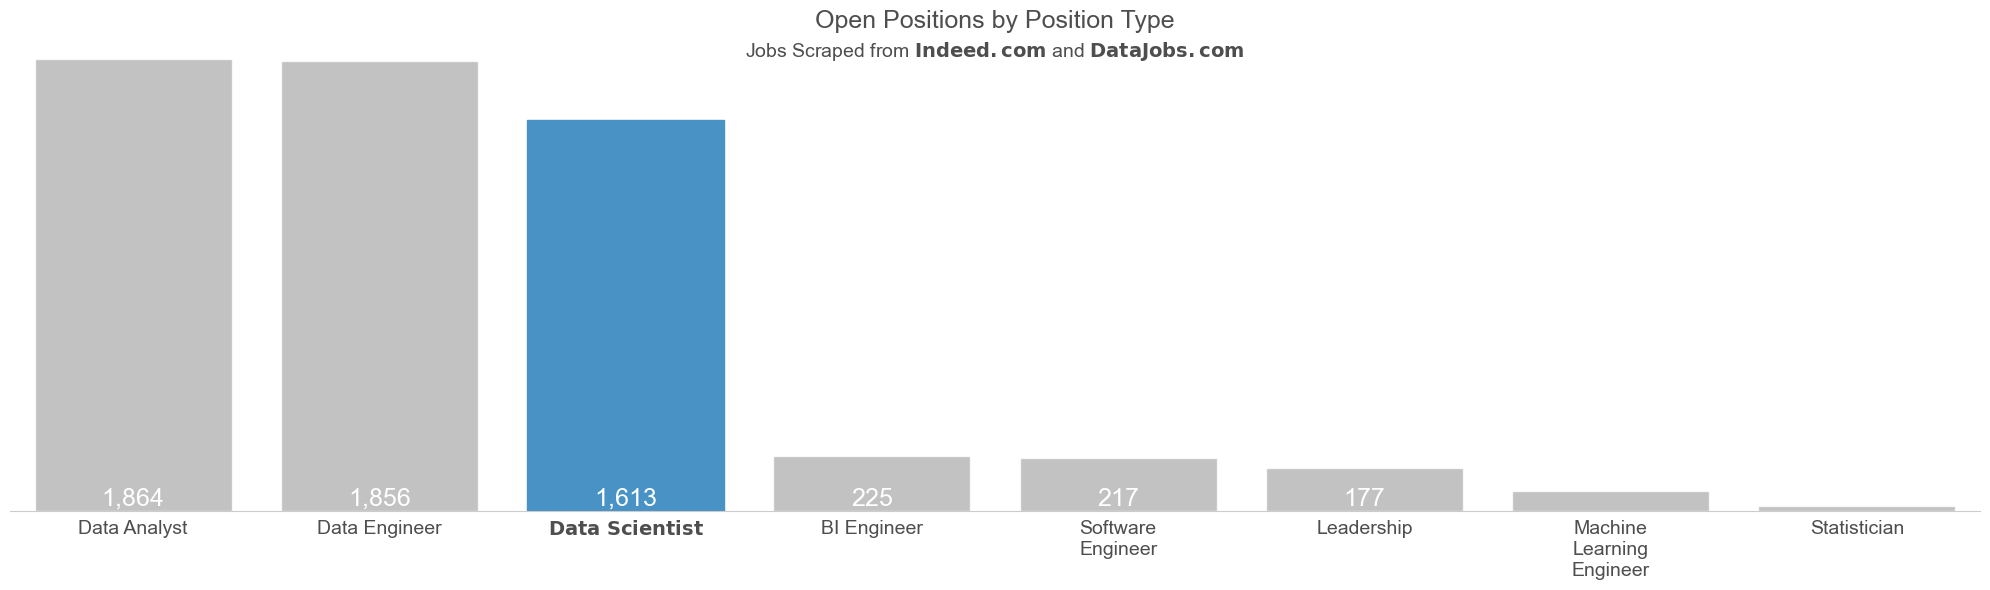

In [7]:
# when you're ready to export uncomment this for a sharper image
# plt.rcParams["figure.dpi"] = 360

f, ax = plt.subplots(figsize=(20, 6))

# we want to look at the number of jobs per "title"
clean_title_counts = job_meta["clean_title"].value_counts().reset_index()

# plot the first few categories
sns.barplot(
    x="clean_title",
    y="count",
    data=clean_title_counts[clean_title_counts["count"] > 1].head(8),
    color=lgrey,
    ax=ax,
)

# we will be following the 'storytelling with data' philosophy of 'less is more'.
# so we will try to remove as much uneccesary information from the plots as possible.
sns.despine(left=True)

# let's label each bar with the count
dlabel_kwargs = default_font_kwargs.copy()
dlabel_kwargs["horizontalalignment"] = "center"
dlabel_kwargs["color"] = bg_color
# loop through each bar
for idx, lbl in enumerate(list(ax.containers[0])):
    h = int(lbl.get_height())
    # if the bar height is less than 100 the text get's too cluttered
    if h > 100:
        plt.text(x=idx, y=20, s=f"{int(lbl.get_height()):,}", **dlabel_kwargs)


# remove axis labels. the title will be illuminating enough.
# this isn't a scientific paper, I just want to give the reader a general idea of what the data looks like
ax.set_ylabel("")
ax.set_xlabel("")

# set the title
title_kwargs = default_font_kwargs.copy()
title_kwargs["horizontalalignment"] = "center"
ax.set_title(f"Open Positions by Position Type", **title_kwargs)

# set the subtitle
# NOTE: you may have to play around with the positioning on your own chart
subtitle_kwargs = default_font_kwargs.copy()
subtitle_kwargs["horizontalalignment"] = "center"
subtitle_kwargs["fontsize"] = 14
plt.text(
    x=3.5,
    y=1870,
    s="Jobs Scraped from $\\bf{Indeed.com}$ and $\\bf{DataJobs.com}$",
    **subtitle_kwargs,
)

# sformat axis label text
plt.xticks(size=14, color=default_font_kwargs["color"])

# again, we want no y axis, minimalizm
plt.yticks([], [])

# there is a weird warning with escaping the space in the data scientist position
# however, escaping is the only way to get the space to show up in the LaTeX.
# This warning is, apparently, unfilterable. So we just have to live with it.

# we want to have the really long job names wrap onto a new line so the
# text doesn't look too cluttered
labels = [item.get_text() for item in ax.get_xticklabels()]
for idx, label in enumerate(labels):
    # if the name of the job is long, we split it onto several lines.
    if len(label) > 14:
        labels[idx] = "\n".join(label.split())
    # two birds: We want to emphasize Data Science Jobs since that is what we are looking for.
    elif label == "Data Scientist":
        labels[idx] = "$\\mathbf{Data\ Scientist}$"
# reset the tick labels with the new strings from above
ax.set_xticklabels(labels=labels)

# let's highlight the postitions we care about
emph_positions = ["Data\ Scientist"]
emph_idx = [labels.index("$\\mathbf{" + pos + "}$") for pos in emph_positions]

# grab the rectangle objects themselves
childrenLS = ax.get_children()
barlist = list(
    filter(lambda x: isinstance(x, matplotlib.patches.Rectangle), childrenLS)
)

# loop through the bars and set the colors
for idx, bar in enumerate(barlist):
    if idx not in emph_idx:
        # we want to de-emphasize non-data scientist jobs
        bar.set(alpha=0.75)
    else:
        # set the data scientist bar to blue!
        bar.set_color(bl)


plt.tight_layout()
# plt.savefig("FIGS/position_types.png")

### 🌎 Data Jobs and Their Locations
The simplest way to visualize this data is to just grab a bar chart. Bar charts are the single most versatile data visualization you can possibly use. They have so many benefits and everyone overlooks them because they're "boring". I argue, and so does Cole Nussbaumer Knaflic in her book [Storytelling with Data](https://www.amazon.com/Storytelling-Data-Visualization-Business-Professionals/dp/1119002257/ref=sr_1_1?crid=38WKFPP6BVOBO&dib=eyJ2IjoiMSJ9.Oe9vJjsIyjvwg1A157HISsMDlEdjNFUg44asaV9vOVjy4WI8Kpd9M24ABIyXPwM6FT7hjWcRcq7NEfmYSKjQb256LSezDJWEpy_mcXp6GZcQHYBucUnIU-UoI91371jSl9JcC1NOi3hU2HVI7skbex-54jV-yUbfvEkcW0095r4ygif_aTq_cEKhPPKVYDh-YkD-Wan2EkRbnaCWnWeILvPOLwHAae5XBySUBkyU_UQ.AOV8A4YRhzB4QKjMRtL6V3ETOnIKhCs_F4kTminM22c&dib_tag=se&keywords=storytelling+with+data&qid=1713942145&sprefix=storytelling%2Caps%2C176&sr=8-1) that it is _because_ they are boring is what makes them so useful! Everyone (and I mean everyone) knows what a bar chart is. Thus, your meaning is never lost on your audience. They will never have to decifer what a chart is telling them.

C:\Users\cbrad\AppData\Local\Temp\ipykernel_404\2334522597.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels=labels)


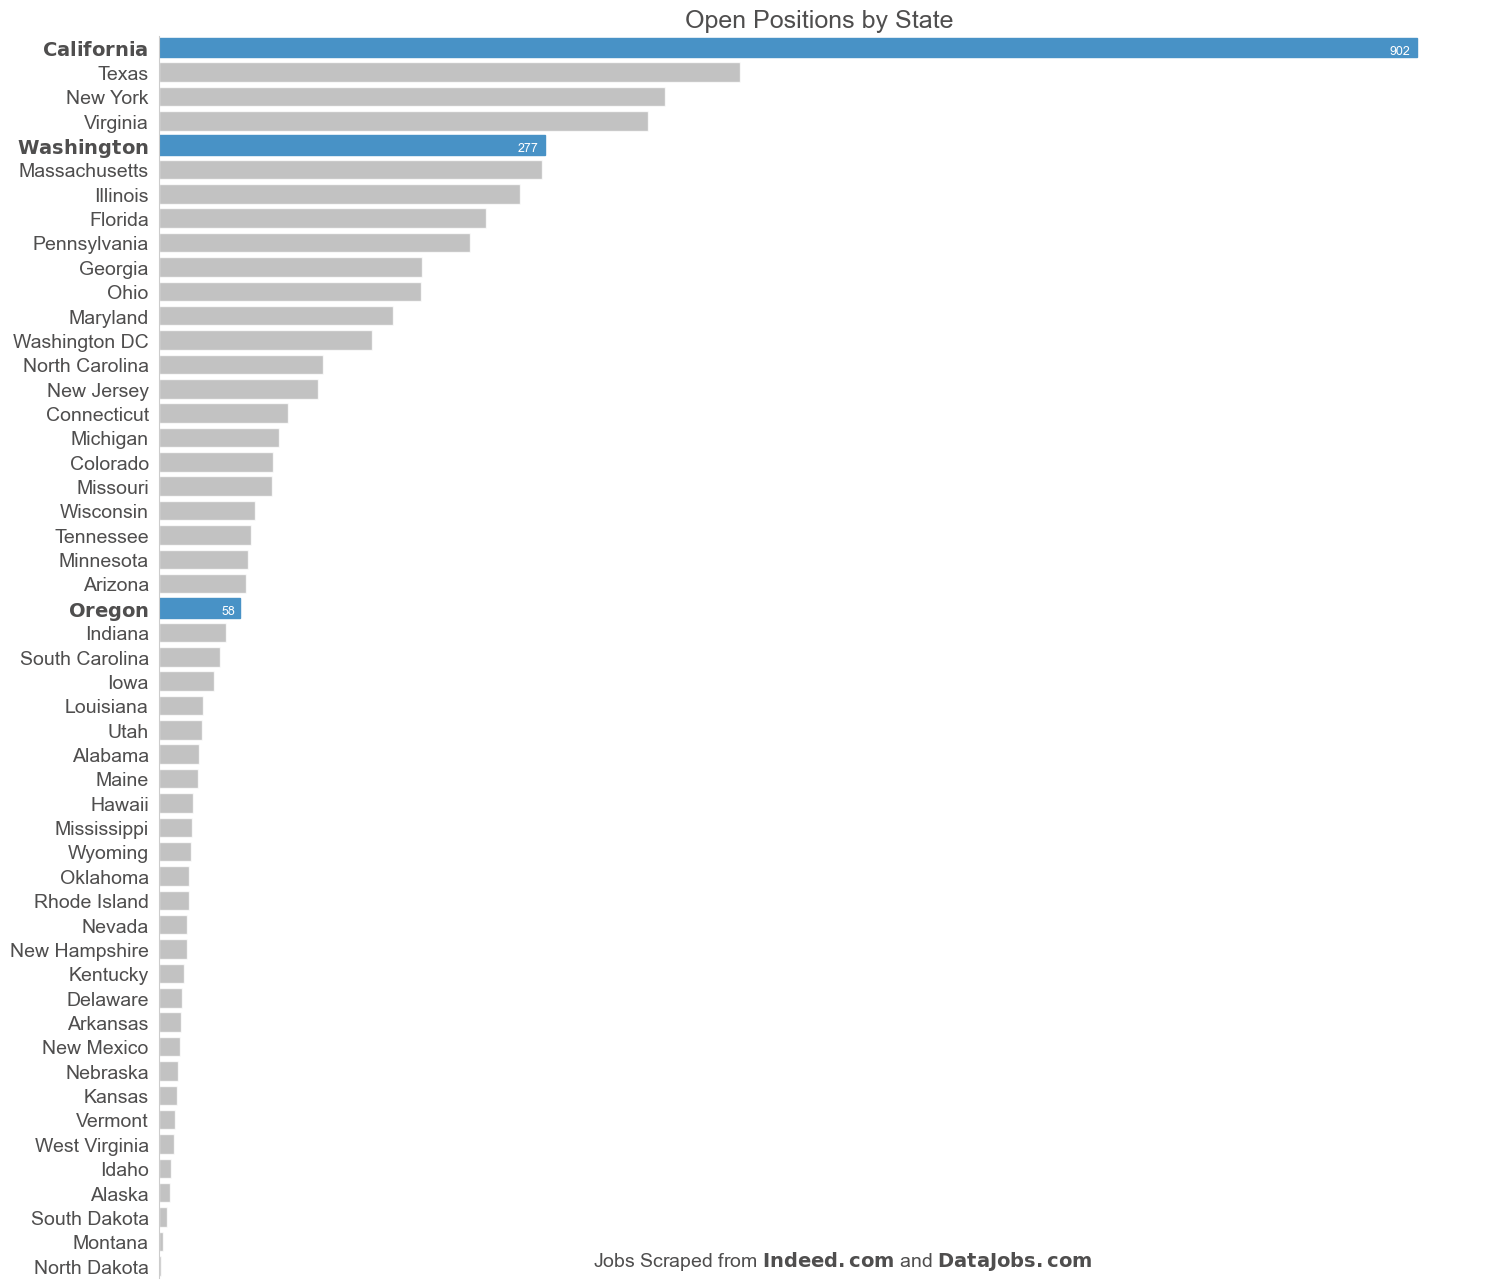

In [8]:
f, ax = plt.subplots(figsize=(15, 13))
# just sum up the number of jobs per state (~10% of jobs state could not be parsed)
num_states = (
    job_meta[job_meta["state"].isin(state_codes)]["state"]
    .value_counts()
    .reset_index()
    .sort_values(by="count", ascending=False)
    .rename({"count": "job_count"}, axis=1)
)
# I'd rather see the actual name of the state rather than just the abbreviated state code
num_states["state_name"] = num_states["state"].apply(lambda x: state_map[x])

# plot the data
sns.barplot(
    y="state_name", x="job_count", data=num_states, color=lgrey, ax=ax, orient="h"
)
# minimalism is your friend
sns.despine(bottom=True)

# the plot is self-explanitory, no need for axis labels
ax.set_ylabel("")
ax.set_xlabel("")

# set up title
ax.set_title(f"Open Positions by State", **title_kwargs)
# set the subtitle
# NOTE: you may have to play around with the positioning on your own chart
plt.text(
    x=490,
    y=50,
    s="Jobs Scraped from $\\bf{Indeed.com}$ and $\\bf{DataJobs.com}$",
    **subtitle_kwargs,
)
# this is all the same as above
plt.yticks(size=14, color=default_font_kwargs["color"])
plt.xticks([], [])

# since I am on the west coast, let's emphasize those states
west_cost = ("California", "Oregon", "Washington")
# loop through the axis labels and bold the west coast states
labels = [item.get_text() for item in ax.get_yticklabels()]
for idx, label in enumerate(labels):
    if label in west_cost:
        labels[idx] = "$\\mathbf{" + label + "}$"
# set new labels to axis
ax.set_yticklabels(labels=labels)

# we will also put these bars in blue as above
emph_idx = [labels.index("$\\mathbf{" + st + "}$") for st in west_cost]
# grab rectangle objects
childrenLS = ax.get_children()
barlist = list(
    filter(lambda x: isinstance(x, matplotlib.patches.Rectangle), childrenLS)
)
# loop through rectangles and de-emphasize non-west coast states and emphasize west coast states
for idx, bar in enumerate(barlist):
    if idx not in emph_idx:
        bar.set(alpha=0.75)
    else:
        bar.set_color(bl)

# let's label the bars for the west coast states as well.
dlabel_kwargs["fontsize"] = 9
for idx, lbl in enumerate(list(ax.containers[0])):
    h = int(lbl.get_width())
    if idx in emph_idx and h >= 100:
        plt.text(y=idx + 0.25, x=int(h) - 12, s=f"{int(h):,}", **dlabel_kwargs)
    elif idx in emph_idx and h < 100:
        plt.text(y=idx + 0.25, x=int(h) - 8, s=f"{int(h):,}", **dlabel_kwargs)
plt.tight_layout()
# plt.savefig("FIGS/position_states.png")

### A More Complex Location Visualization

A choropleth plot is a density plot integrated with a map of some sort. For our data, we can visualize the number of jobs per state on a map of the United States using **geopandas** and **shapely**. 

*Check out [this blog post](https://medium.com/@alex_44314/use-python-geopandas-to-make-a-us-map-with-alaska-and-hawaii-39a9f5c222c6) that explains how to create this plot!*

> **Note**: To create this map, you will need to download the United States geospatial [shape file](https://www2.census.gov/geo/tiger/GENZ2018/shp)

In [9]:
# I wanted to create a chloropleth map for the jobs/state visualization as I think they are nicer to look at than just a bar chart.
# most of this code comes from: https://medium.com/@alex_44314/use-python-geopandas-to-make-a-us-map-with-alaska-and-hawaii-39a9f5c222c6
# first we need to get the shape files for the US states in order to plot them
# NOTE: these can be downloaded here: https://www2.census.gov/geo/tiger/GENZ2018/shp
gdf1 = gpd.read_file("./SHAPES/cb_2018_us_state_500k")
# now we can just merge this in with out count data from above
gdf = gdf1.merge(num_states, left_on="STUSPS", right_on="state", how="left")
gdf.job_count.fillna(0, inplace=True)
# there are some non major-50 state codes in here (like Puerto Rico [PR] and Virgin Islands [VI])
gdf = gdf[gdf.STUSPS.isin(state_codes)]


# Apply this to the gdf to ensure all states are assigned colors by the same func
def makeColorColumn(gdf, variable, vmin, vmax):
    # apply a function to a column to create a new column of assigned colors & return full frame
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Blues)
    gdf["value_determined_color"] = gdf[variable].apply(
        lambda x: mcolors.to_hex(mapper.to_rgba(x))
    )
    return gdf

C:\Users\cbrad\AppData\Local\Temp\ipykernel_404\563357401.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gdf.job_count.fillna(0, inplace=True)


c:\Users\cbrad\miniconda3\envs\datajobs\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cbrad\AppData\Local\Temp\ipykernel_404\3206272889.py:86: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  hawaii_gdf.clip(hipolygon).plot(


<Axes: >

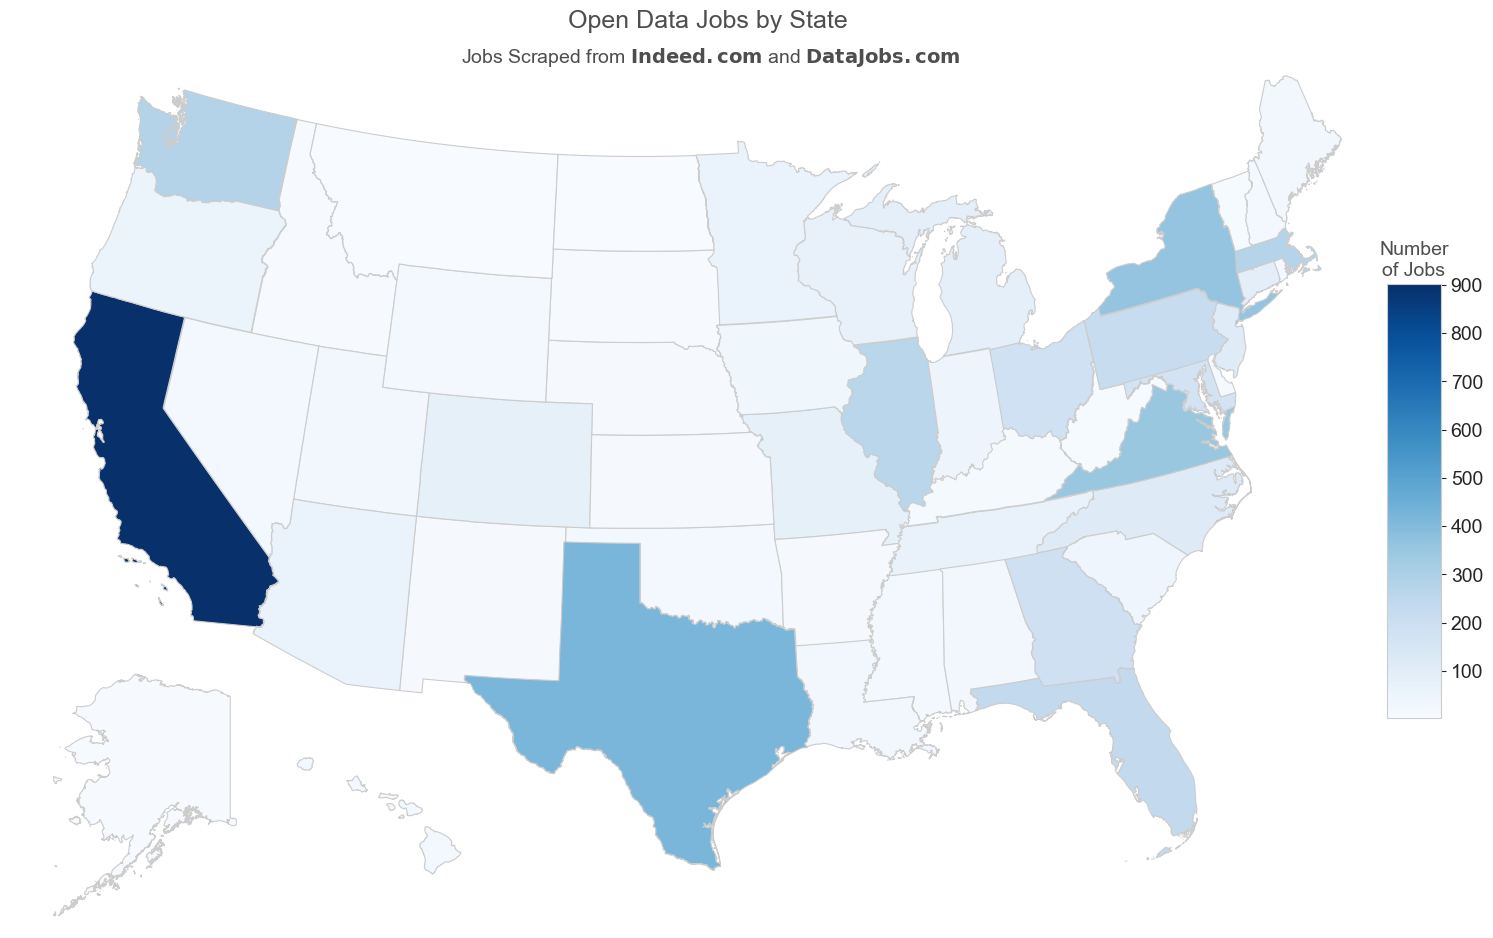

In [10]:
# set the value column that will be visualised
variable = "job_count"
state_var = "STUSPS"

# make a column for value_determined_color in gdf
# set the range for the choropleth values with the upper bound the rounded up maximum value
vmin, vmax = gdf[variable].min(), gdf[variable].max()
# this is the color map we have been using (this looks better here than the dark version of the map)
colormap = "Blues"
gdf = makeColorColumn(gdf, variable, vmin, vmax)

# create "visframe" as a re-projected gdf using EPSG 2163 for CONUS
# this is just a specific mapping projection
visframe = gdf.to_crs({"init": "epsg:2163"})

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(18, 14))
# remove the axis box around the vis
ax.axis("off")

# add a title and annotation
ax.set_title("Open Data Jobs by State", **title_kwargs)
ax.annotate(
    "Jobs Scraped from $\\bf{Indeed.com}$ and $\\bf{DataJobs.com}$",
    xy=(0.395, 0.625),
    xycoords="figure fraction",
    **subtitle_kwargs
)

fig = ax.get_figure()
# add colorbar axes to the figure
# This will take some iterating to get it where you want it [l,b,w,h] right
# l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
cbax = fig.add_axes([0.89, 0.32, 0.03, 0.31])

cbax.set_title("Number\nof Jobs", **subtitle_kwargs)

# add color scale
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# reformat tick labels on legend
sm._A = []
# comma_fmt = FuncFormatter(lambda x, p: format(x/100, '.0%'))
fig.colorbar(sm, cax=cbax)
tick_font_size = 14
cbax.tick_params(labelsize=tick_font_size)

# create map
# Note: we're going state by state here because of unusual coloring behavior when trying to plot the entire dataframe using the "value_determined_color" column
for idx, row in visframe.iterrows():

    if row[state_var] not in ["AK", "HI"]:
        try:
            vf = visframe[visframe[state_var] == row[state_var]]
            c = gdf[gdf[state_var] == row[state_var]][0:1].value_determined_color.item()
        except:
            print(
                vf,
                gdf[gdf[state_var] == row[state_var]][0:1][
                    ["STUSPS", "value_determined_color"]
                ],
                sep="\n" * 2,
            )
        else:
            vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor="0.8")

# add Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])
akax.axis("off")
# polygon to clip western islands
polygon = Polygon([(-170, 50), (-170, 72), (-140, 72), (-140, 50)])
alaska_gdf = gdf[gdf[state_var] == "AK"]
alaska_gdf.clip(polygon).plot(
    color=gdf[gdf[state_var] == "AK"].value_determined_color,
    linewidth=0.8,
    ax=akax,
    edgecolor="0.8",
)


# add Hawaii
hiax = fig.add_axes([0.28, 0.20, 0.1, 0.1])
hiax.axis("off")
# polygon to clip western islands
hipolygon = Polygon([(-160, 0), (-160, 90), (-120, 90), (-120, 0)])
hawaii_gdf = gdf[gdf[state_var] == "HI"]
hawaii_gdf.clip(hipolygon).plot(
    column=variable,
    color=hawaii_gdf["value_determined_color"].values[0],
    linewidth=0.8,
    ax=hiax,
    edgecolor="0.8",
)
# plt.tight_layout()
# plt.savefig("FIGS/position_density_chloropleth.png", dpi=fig.dpi)

### 🔍 Key Skills for Data Job Seekers
In this section, I dive into the specific skills that are in demand for Data Science, Analytics, and Engineering jobs. By scraping job meta-information (location, salary, etc.) and the job posting itself, we can collect and analyze the job descriptions to count how often certain key data-related skills are mentioned. The results are displayed in a bar chart, highlighting the frequency of keywords such as "Python," "SQL," "machine learning," and more. This visualization helps identify the most sought-after skills in the industry, giving job seekers a clear picture of what to prioritize in their learning and development.

In [11]:
def kw_counter(text, kws):
    """
    kw_counter will count all instances of the keywords in the kws list in the text variable.

    Inputs:
    -------
        text -> (str): this is the raw text to extract the keyword counts from. It does not need to be lowered.
        kws -> (list): the keywords to be searched for
            NOTE: the function handles some keywords for which there could be multiple spellings. You may need to adjust this to add more.
            NOTE: spaces are appended to the beginning and end of each keyword as not to match partially on words that we are not interested in
    Outputs:
    --------
        kws_coutns -> (dict): a dictionary containing the keywords from kws and the counts of those keywords in text.
    """
    # this will hold our keyword counts
    kws_counts = {}
    # loop through the keywords
    for kw in kws:
        # set the initial keyword count to 0 (this is because we are using the += operator)
        kws_counts[kw] = 0

        # each conditional handles keywords for which there could be multiple spellings
        if kw == "Scikit-learn":
            kws_counts[kw] += text.lower().count(" " + kw.lower() + " ")
            kws_counts[kw] += text.lower().count(" scikitlearn ")
            kws_counts[kw] += text.lower().count(" scikit learn ")
            kws_counts[kw] += text.lower().count(" sci kit learn ")
        elif kw == "PowerBI":
            kws_counts[kw] += text.lower().count(" " + kw.lower() + " ")
            kws_counts[kw] += text.lower().count(" Power-BI ")
            kws_counts[kw] += text.lower().count(" Power BI ")
        elif kw == "Time-Series":
            kws_counts[kw] += text.lower().count(" " + kw.lower() + " ")
            kws_counts[kw] += text.lower().count(" time series ")
        elif kw == "A/B Testing":
            kws_counts[kw] += text.lower().count(" a/b test")
            kws_counts[kw] += text.lower().count(" ab test")
            kws_counts[kw] += text.lower().count(" a-b test")
        elif kw == "GCP":
            kws_counts[kw] += text.lower().count(" " + kw.lower() + " ")
            kws_counts[kw] += text.lower().count(" google cloud ")
        elif kw == "AWS":
            kws_counts[kw] += text.lower().count(" " + kw.lower() + " ")
            kws_counts[kw] += text.lower().count(" amazon web services ")
        elif kw == "Webscraping":
            kws_counts[kw] += text.lower().count(" webscrap")
            kws_counts[kw] += text.lower().count(" web scrap ")
        elif kw == "CNN":
            kws_counts[kw] += text.lower().count(" " + kw.lower() + " ")
            kws_counts[kw] += text.lower().count(" convolutional neural network ")
        elif kw == "ANN":
            kws_counts[kw] += text.lower().count(" " + kw.lower() + " ")
            kws_counts[kw] += text.lower().count(" artificial neural network ")
        elif kw == "RNN":
            kws_counts[kw] += text.lower().count(" " + kw.lower() + " ")
            kws_counts[kw] += text.lower().count(" recurrent neural network ")
        elif kw == "LSTM":
            kws_counts[kw] += text.lower().count(" " + kw.lower() + " ")
            kws_counts[kw] += text.lower().count(" long-term short-term memory ")
            kws_counts[kw] += text.lower().count(" long term short term memory ")
        elif kw == "Semi-Supervised Learning":
            kws_counts[kw] += text.lower().count(" " + kw.lower() + " ")
            kws_counts[kw] += text.lower().count(" semi supervised learning ")
        elif kw == "Forecasting":
            kws_counts[kw] += text.lower().count(" forecast")
        elif kw == "Presentation":
            kws_counts[kw] += text.lower().count(" present")
        elif kw == "Communication":
            kws_counts[kw] += text.lower().count(" " + kw.lower() + " ")
            kws_counts[kw] += text.lower().count(" communicate ")
        elif kw == "Collaboration":
            kws_counts[kw] += text.lower().count(" " + kw.lower() + " ")
            kws_counts[kw] += text.lower().count(" collaborate ")
        elif kw == "Adaptability":
            kws_counts[kw] += text.lower().count(" " + kw.lower() + " ")
            kws_counts[kw] += text.lower().count(" adapt ")
            kws_counts[kw] += text.lower().count(" adaptable ")
        elif kw == "Independence":
            kws_counts[kw] += text.lower().count(" " + kw.lower() + " ")
            kws_counts[kw] += text.lower().count(" independent ")
        elif kw == "Creativity":
            kws_counts[kw] += text.lower().count(" " + kw.lower() + " ")
            kws_counts[kw] += text.lower().count(" creative ")
        else:
            # finally, if it is not one of the above keywords, just search for it normally.
            kws_counts[kw] += text.lower().count(" " + kw.lower() + " ")

    return kws_counts

In [12]:
# grab the list of all buzz words (these are separated for a particular reason we will see below)
buzz_words = (
    programming_languages
    + libraries
    + dev_tools
    + viz_tools
    + databases
    + soft_skills
    + concepts
)

# get one long string of job descriptions
job_descs_concat = job_descriptions["desc"].str.cat(sep=" ")

# this just counts all the keywords in all the jobs
all_counts = kw_counter(text=job_descs_concat, kws=buzz_words)

# we want to sort this for plotting reasons
keys = list(all_counts.keys())
values = list(all_counts.values())
# [::-1] reverses the sort (from ascending to descending)
sorted_value_index = np.argsort(values)[::-1]
all_counts_sort = {keys[i]: values[i] for i in sorted_value_index}

<>:83: SyntaxWarning: invalid escape sequence '\ '
<>:83: SyntaxWarning: invalid escape sequence '\ '
C:\Users\cbrad\AppData\Local\Temp\ipykernel_404\4278132945.py:83: SyntaxWarning: invalid escape sequence '\ '
  labels[idx] = lbl_str.replace(" ", "\ ")
C:\Users\cbrad\AppData\Local\Temp\ipykernel_404\4278132945.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


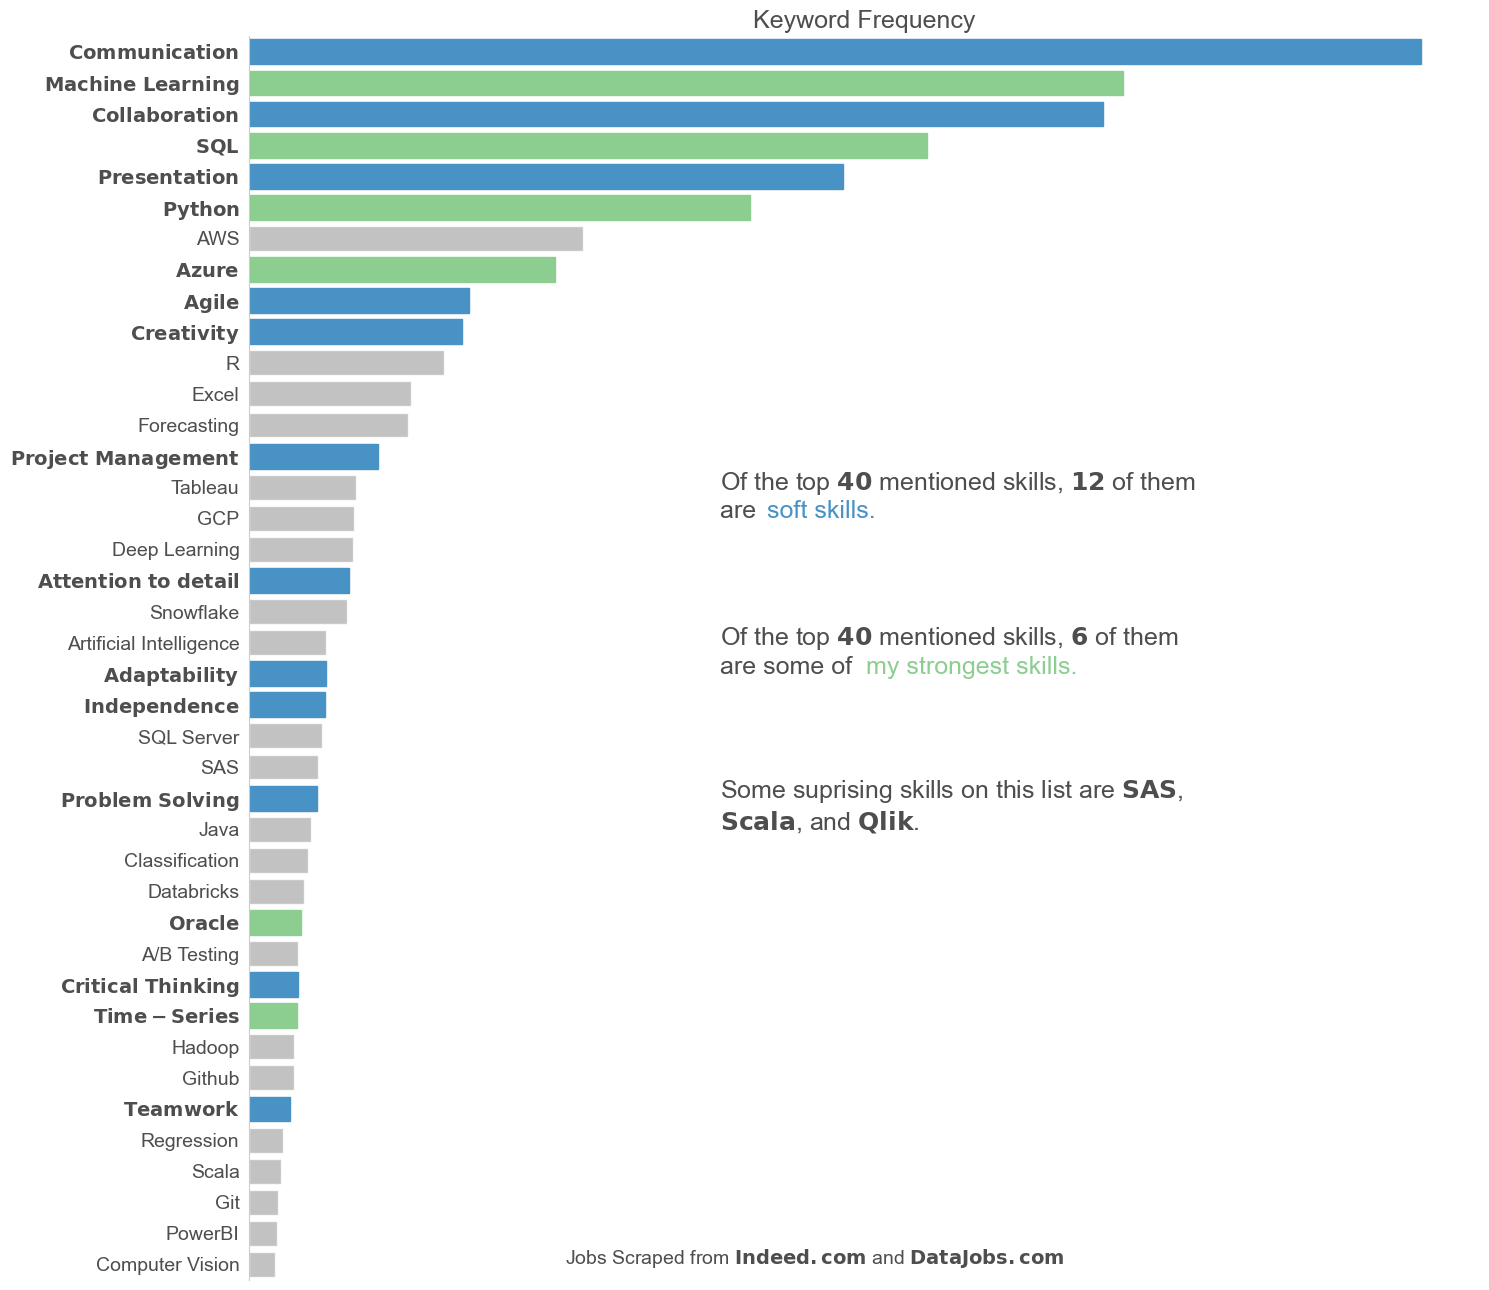

In [13]:
from itertools import islice


def take(n, iterable):
    """Return the first n items of the iterable as a list."""
    return dict(islice(iterable, n))


# we only want to check out the top-40 skills
viz_counts = take(n=40, iterable=all_counts_sort.items())

f, ax = plt.subplots(figsize=(15, 13))

# plot our counts
sns.barplot(
    y=list(viz_counts.keys()),
    x=list(viz_counts.values()),
    color=lgrey,
    ax=ax,
    orient="h",
)
# minimalism is your friend
sns.despine(bottom=True)

# set titles and subtitles
ax.set_title(f"Keyword Frequency", **title_kwargs)
plt.text(
    x=3000,
    y=39,
    s="Jobs Scraped from $\\bf{Indeed.com}$ and $\\bf{DataJobs.com}$",
    **subtitle_kwargs,
)


# this plot had a lot of white space so I wanted to fill it with some interesting facts about the data
pos_text_x = 2500
pos_text_y = 15
plt.text(
    x=pos_text_x,
    y=pos_text_y,
    s="Of the top $\\bf{40}$ mentioned skills, $\\bf{12}$ of them \nare ",
    **default_font_kwargs,
)
bl_kwargs = default_font_kwargs.copy()
bl_kwargs["color"] = bl
plt.text(x=pos_text_x + 250, y=pos_text_y + 0.001, s=r"soft skills.", **bl_kwargs)

pos_text_x = 2500
pos_text_y = 20
plt.text(
    x=pos_text_x,
    y=pos_text_y,
    s="Of the top $\\bf{40}$ mentioned skills, $\\bf{6}$ of them \nare some of ",
    **default_font_kwargs,
)
gr_kwargs = default_font_kwargs.copy()
gr_kwargs["color"] = gr
plt.text(
    x=pos_text_x + 775, y=pos_text_y + 0.001, s=r"my strongest skills.", **gr_kwargs
)

pos_text_x = 2500
pos_text_y = 25
plt.text(
    x=pos_text_x,
    y=pos_text_y,
    s="Some suprising skills on this list are $\\bf{SAS}$, \n$\\bf{Scala}$, and $\\bf{Qlik}$.",
    **default_font_kwargs,
)

plt.yticks(size=14, color=default_font_kwargs["color"])
plt.xticks([], [])

# we want to highlight my skills and the soft skills, as they appear in job descriptions quite often and people tend to not focus on them
my_skills = ["Python", "SQL", "Machine Learning", "Time-Series", "Azure", "Oracle"]
labels = [item.get_text() for item in ax.get_yticklabels()]
emph_idx_ss = []
emph_idx_ms = []
# loop through the y axis labels and bold the ones that are my skills or soft skills
for idx, label in enumerate(labels):
    if label in soft_skills + my_skills:
        lbl_str = "$\\mathbf{" + label + "}$"
        labels[idx] = lbl_str.replace(" ", "\ ")
        if label in soft_skills:
            emph_idx_ss.append(idx)
        else:
            emph_idx_ms.append(idx)

ax.set_yticklabels(
    labels=labels, color=subtitle_kwargs["color"], fontsize=subtitle_kwargs["fontsize"]
)

# we also want to highlight the bars in other colors
childrenLS = ax.get_children()
barlist = list(
    filter(lambda x: isinstance(x, matplotlib.patches.Rectangle), childrenLS)
)

for idx, bar in enumerate(barlist):
    if idx not in emph_idx_ss and idx not in emph_idx_ms:
        # de-emphasize the columns that are not in the skills I want to highlight
        bar.set(alpha=0.75)
    elif idx in emph_idx_ss:
        bar.set_color(bl)
    elif idx in emph_idx_ms:
        bar.set_color(gr)
plt.tight_layout()
# plt.savefig("FIGS/keyword_bar.png")

### 🌥️ Wordclouds... I love them!

While bar charts are great, I want a more intuitive way to see which skills are essential for a career in Data Science and Analytics. Word clouds are perfect for this because they instantly show the audience what’s important. They’re much more visually engaging than bar charts and give a quick, holistic view of the data. Plus, they save a ton of space!

In [14]:
# let's try it with removing stop words
from nltk.corpus import stopwords

# I want to filter out the normal stop words but also any words that appear in job descriptions
# frequently that aren't really helpful in understanding the job descipription. Like 'Veteran Status' and
# 'Equal Opportunity Employer'
stop_words = set(stopwords.words("english"))

# I just removed words that I saw in the word clouds that aren't very helpful. This may be different for you
stop_words.update(
    [
        "team",
        "provde",
        "will",
        "year",
        "working",
        "work",
        "experience",
        "provide",
        "management",
        "including",
        "project",
        "develop",
        "development",
        "need",
        "drive",
        "using",
        "build",
        "service",
        "e",
        "g",
        "etc",
        "use",
        "within",
        "well",
        "ability",
        "needs",
        "based",
        "must",
        "level",
        "various",
        "include",
        "group",
        "year",
        "staff",
        "position",
        "area",
        "new",
        "data",
        "preferred qualification",
        "related field",
        "sexual orientation",
        "dental",
        "vision",
        "equal opportunity",
        "job description",
    ]
)

# set up a "clean" column
job_descriptions["desc_stop_rem"] = ""

# loop through the job descriptions and clean out the stop words
for idx, row in job_descriptions.iterrows():
    p1 = re.sub(r"[^A-Za-z0-9-\+#]+", " ", row["desc"]).lower()
    for sw in stop_words:
        p1 = p1.replace(f" {sw} ", " ")

    job_descriptions.loc[idx, "desc_stop_rem"] = p1

In [15]:
def create_word_cloud(job_descriptions: pd.DataFrame, job_type: str = '', savefig: bool = False):
    """
    create_word_cloud will subset the job data to a specific job title (as they appear in the "clean_title" feature) and visualize the job descriptions in a word cloud

    Inputs:
    -------
        job_descriptions: pd.DataFrame || This is the dataframe containing all the job descriptions we want to create a word cloud for.
        job_type: str || This is the job title (Data Scientist, Data Engineer, etc.). This title must appear in the "clean_title" variable. Check the JobScraper.py file for details
        savefig: bool || tells the function to save the figure in the FIGS folder
    Outputs:
    --------

    """

    # if there is a job type specified subset the data to the job type.
    if job_type != '':
        df = job_descriptions[job_descriptions['job_id'].isin(job_meta[job_meta.clean_title == job_type]['job_id'])]
    else:
        df = job_descriptions
        job_type = 'All'

    # set up the wordcloud object
    wordcloud = WordCloud(background_color = 'white', 
                          max_words = 100, 
                          height = 400, 
                          width = 1000, 
                          colormap='Blues_r', # this colormap ensures the highest frequency words are darkest
                          min_word_length = 3).generate(' '.join(df['desc_stop_rem']))

    f, ax = plt.subplots(figsize=(15,8))

    # this is standardized across all the plots in this notebook
    ax.set_title(f'Keyword Frequency: {job_type}', **title_kwargs);
    plt.text(x=500, y=420, s='Jobs Scraped from $\\bf{Indeed.com}$ and $\\bf{DataJobs.com}$', **subtitle_kwargs)

    # Display the generated image:
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    plt.tight_layout()
    if savefig:
        plt.savefig(f'FIGS/wc_{job_type.replace(' ','_')}.png');

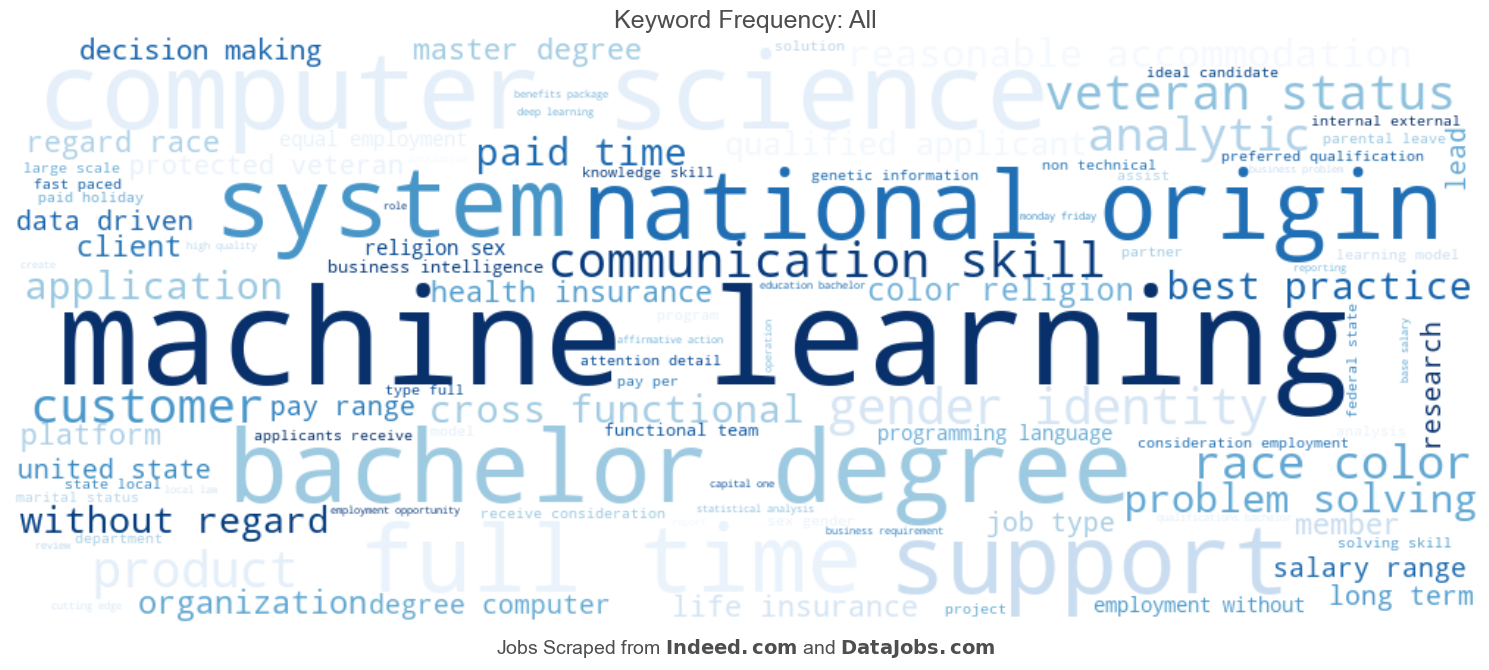

In [16]:
# wordcloud for all job types
savefig = False
create_word_cloud(job_descriptions = job_descriptions, savefig=savefig)

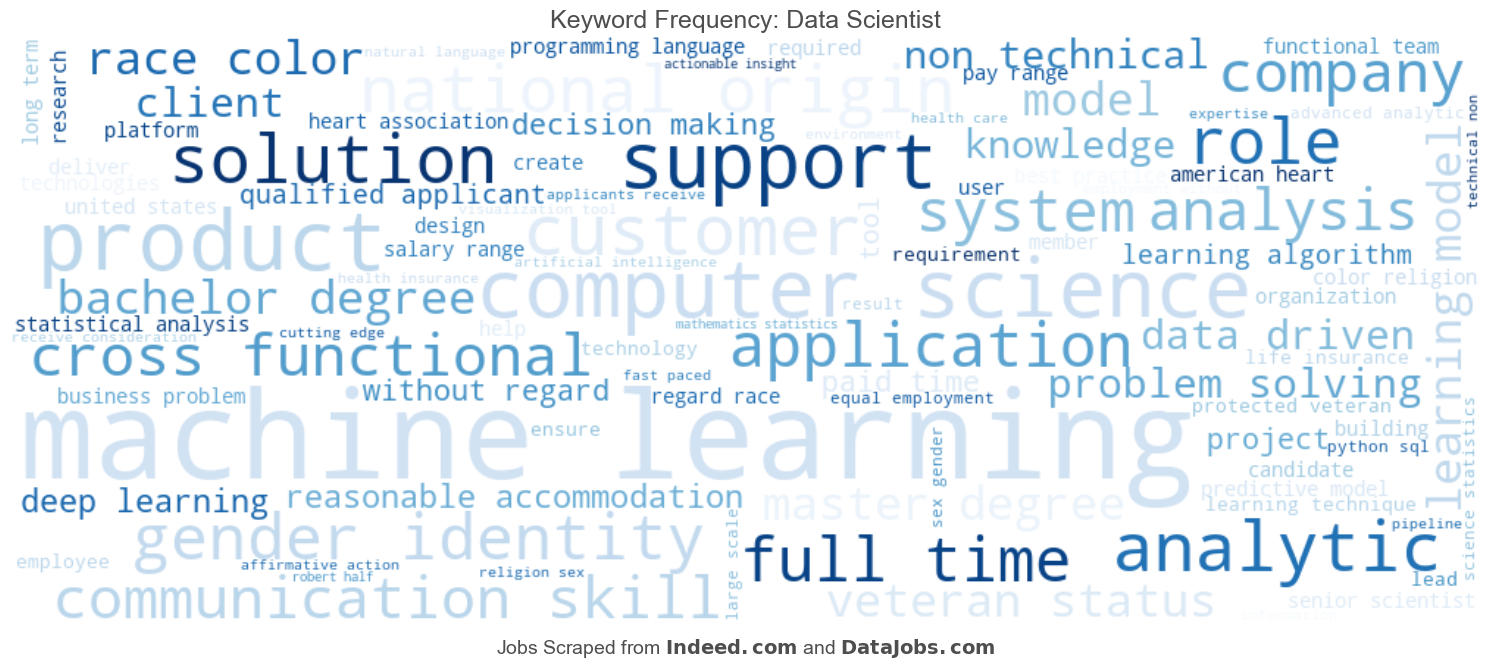

In [17]:
create_word_cloud(job_descriptions = job_descriptions, job_type='Data Scientist', savefig=savefig)

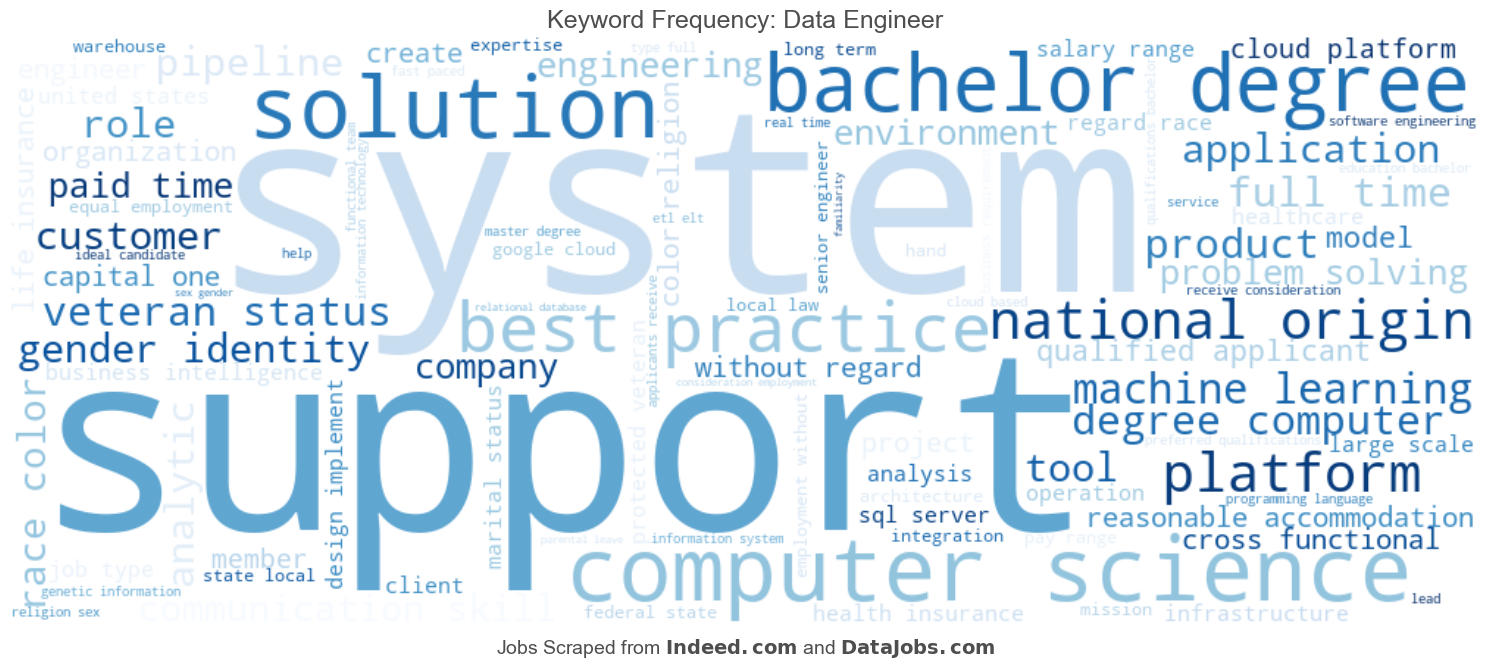

In [18]:
create_word_cloud(job_descriptions = job_descriptions, job_type='Data Engineer', savefig=savefig)

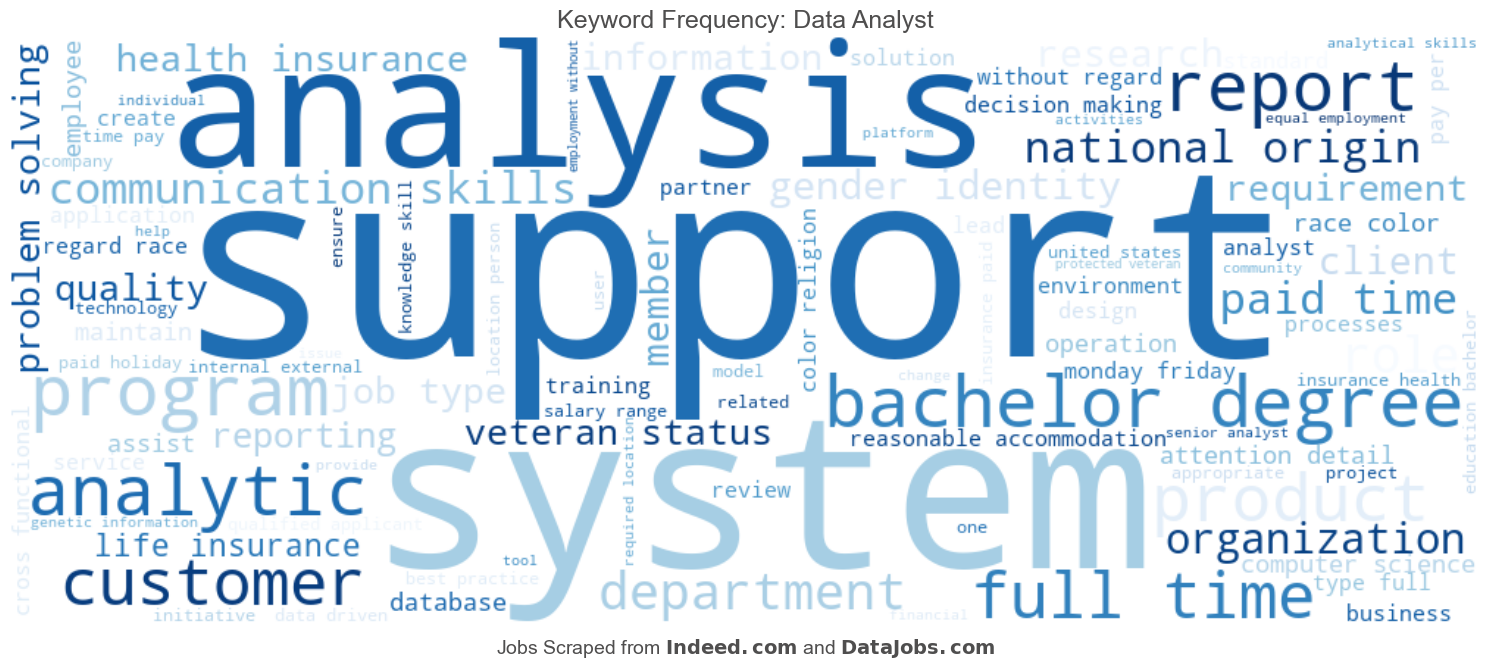

In [19]:
create_word_cloud(job_descriptions = job_descriptions, job_type='Data Analyst', savefig=savefig)

### A Better Word Cloud

These word clouds are pretty good for giving us a general sense of what these positions entail. For example, we can see common data science buzzwords like "Machine Learning" and "Statistical Analysis" popping up in job postings. However, general word clouds don't provide much insight into the specific tools and soft skills required for these roles. Since I want to improve my marketability, I need to know exactly what employers are looking for when hiring new candidates. A better approach is to count the instances of specific words and phrases in these job descriptions. Then we can gather these counts into a cleaner visualization that categorizes each type of word or phrase. First, let's define some lists of words we want to consider.

> **Note**: I got a lot of great ideas from a great [article](https://www.ischool.berkeley.edu/news/2019/word-clouds-we-cant-make-them-go-away-so-lets-improve-them) by Marti Hearst for this visualization. 

In [20]:
# NOTE: We aren't including Go as it is hard to distinguish it from the regular word.
# TODO: try to find that analyst influencers tool to add some stuff to this
# we want to grab job counts for each category of keyword we are interested in
job_descs_concat = job_descriptions["desc"].str.cat(sep=" ").lower()
language_counts = kw_counter(text=job_descs_concat, kws=programming_languages)
library_counts = kw_counter(text=job_descs_concat, kws=libraries)
dev_tools_counts = kw_counter(text=job_descs_concat, kws=dev_tools + viz_tools)
databases_counts = kw_counter(text=job_descs_concat, kws=databases)
soft_skills_counts = kw_counter(text=job_descs_concat, kws=soft_skills)

Now that we have defined some keywords we want to search for, let's count them in our list of descriptions. Let's first visualize just using a static matplotlib visualizer...

C:\Users\cbrad\AppData\Local\Temp\ipykernel_404\875345316.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


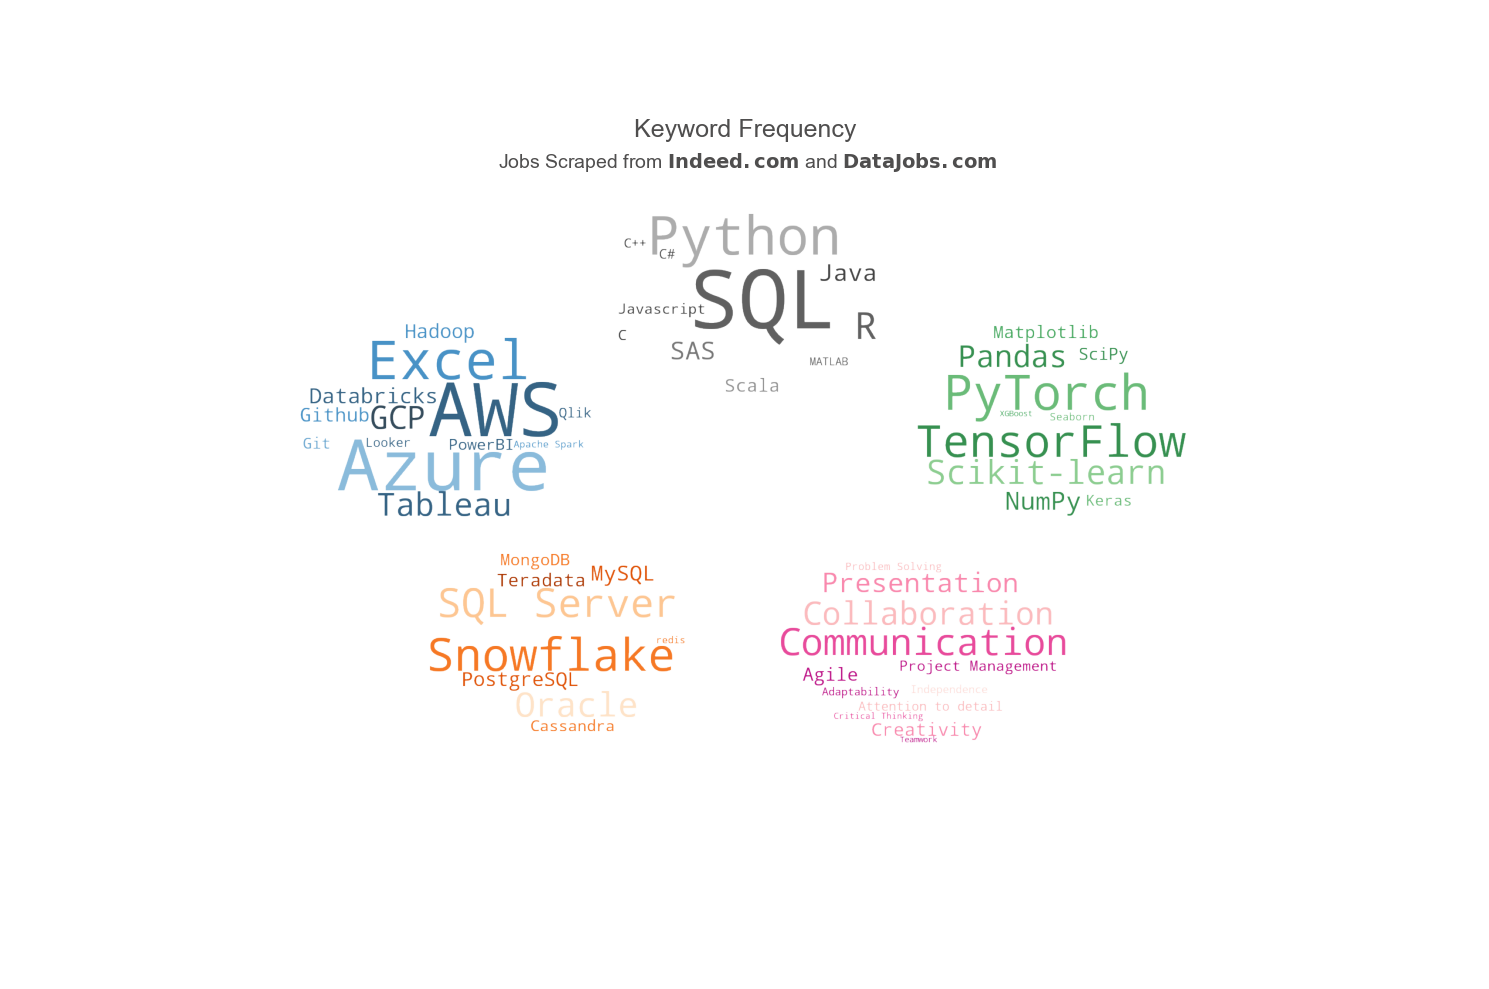

In [21]:
# this mask will force our word cloud into a nice
mask = np.array(Image.open("IMG\\ellipse.png"))

fig, ax = plt.subplots(figsize=(15, 10))
ax.axis("off")

# we will organize our five word clouds in a star shape
# you can play around with these parameters to adjust the positions and sizes of the sub-axes
main = 0.5
width = 0.30
offset = 0.20

wc_width = 1500
wc_height = 1000

upax = fig.add_axes([main - width / 2, main + offset - width / 2, width, width])
# add a title and subtitle to the upper wordcloud
upax.set_title(f"Keyword Frequency", **title_kwargs)
plt.text(
    x=260,
    y=39,
    s="Jobs Scraped from $\\bf{Indeed.com}$ and $\\bf{DataJobs.com}$",
    **subtitle_kwargs,
)

# all of these calcs are to try to get a nice evenly spaced pentagon
uprightax = fig.add_axes(
    [main + offset - width / 2, main + 0.70 * offset / 2 - width / 2, width, width]
)
upleftax = fig.add_axes(
    [main - offset - width / 2, main + 0.70 * offset / 2 - width / 2, width, width]
)

downrightax = fig.add_axes(
    [main + 0.60 * offset - width / 2, main - 0.75 * offset - width / 2, width, width]
)
downleftax = fig.add_axes(
    [main - 0.60 * offset - width / 2, main - 0.75 * offset - width / 2, width, width]
)

# this wordcloud is for programming languages
wordcloud = WordCloud(
    background_color="rgba(255, 255, 255, 0)",
    mode="RGBA",
    mask=mask,
    max_words=100,
    height=wc_height,
    width=wc_width,
    colormap=ListedColormap(sns.color_palette("Greys_d").as_hex()),
    min_word_length=3,
    prefer_horizontal=1,
    min_font_size=18,
    max_font_size=140,
).generate_from_frequencies(language_counts)


# Display the generated image:
upax.imshow(wordcloud, interpolation="bilinear")
upax.axis("off")

# this wordcloud is for R and Python libraries
wordcloud = WordCloud(
    background_color="rgba(255, 255, 255, 0)",
    mode="RGBA",
    mask=mask,
    max_words=100,
    height=wc_height,
    width=wc_width,
    colormap=ListedColormap(sns.color_palette("Greens_d").as_hex()),
    min_word_length=3,
    prefer_horizontal=1,
    min_font_size=14,
).generate_from_frequencies(library_counts)


# Display the generated image:
uprightax.imshow(wordcloud, interpolation="bilinear")
uprightax.axis("off")

# this wordcloud is for developer tools such as cloud services and visualization tools
wordcloud = WordCloud(
    background_color="rgba(255, 255, 255, 0)",
    mode="RGBA",
    mask=mask,
    max_words=100,
    height=wc_height,
    width=wc_width,
    colormap=ListedColormap(sns.color_palette("Blues_d").as_hex()),
    min_word_length=3,
    prefer_horizontal=1,
    min_font_size=14,
).generate_from_frequencies(dev_tools_counts)


# Display the generated image:
upleftax.imshow(wordcloud, interpolation="bilinear")
upleftax.axis("off")


# this word cloud is for database tools
wordcloud = WordCloud(
    background_color="rgba(255, 255, 255, 0)",
    mode="RGBA",
    mask=mask,
    max_words=100,
    height=wc_height,
    width=wc_width,
    colormap=ListedColormap(sns.color_palette("Oranges").as_hex()),
    min_word_length=3,
    prefer_horizontal=1,
    min_font_size=14,
).generate_from_frequencies(databases_counts)


# Display the generated image:
downleftax.imshow(wordcloud, interpolation="bilinear")
downleftax.axis("off")

# this word cloud is for soft skills
wordcloud = WordCloud(
    background_color="rgba(255, 255, 255, 0)",
    mode="RGBA",
    mask=mask,
    max_words=100,
    height=wc_height,
    width=wc_width,
    colormap=ListedColormap(sns.color_palette("RdPu").as_hex()),
    min_word_length=3,
    prefer_horizontal=1,
    min_font_size=14,
    max_font_size=100,
).generate_from_frequencies(soft_skills_counts)


# Display the generated image:
downrightax.imshow(wordcloud, interpolation="bilinear")
downrightax.axis("off")

plt.tight_layout()
# plt.savefig("FIGS/wc_specific.png")

### 💰 Data Job Salaries

Finally, let's take a peek at the salaries for these positions. I'd like to know if it is true that Data Scientists make more money than analysts. I'd also love to know the range of salaries for these positions. A box-and-whisker plot is great for this! We also can look at the highest paying states as well!

> You may be asking yourself, "Colin, why use a box-and-whisker plot when the violin plot packs in so much more data?" I asked myself this question as well. However, I believe the box and whisker plot packs in nearly as much information as a violin plot, and it has the advantage of being more universally understood as a visualization. An audience will never remember that the distribution of Data Scientist salaries is bimodal, but they will remember that the mean is around $130,000.

In [22]:
# now let's set up a dataframe so we can grab boxplots of the salaries for the 3 main job types (data analyst, data scientist, and data engineer)
# the upper vs the lower salary ranges will be two separate box plots per job type (or the "hue")
df = (
    job_meta[
        job_meta["clean_title"].isin(
            ["Data Scientist", "Data Analyst", "Data Engineer"]
        )
    ]
    .melt(
        id_vars=["clean_title", "job_id", "site"],
        value_vars=["salary_lower", "salary_upper"],
        var_name="Salary Type",
        value_name="Salary",
    )
    .sort_values(by=["job_id", "site"])
    .dropna(subset=["Salary"])
).replace(
        {"salary_lower": "Salary Range (Lower)", "salary_upper": "Salary Range (Upper)"}
    )

C:\Users\cbrad\AppData\Local\Temp\ipykernel_404\3853477964.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=labels)


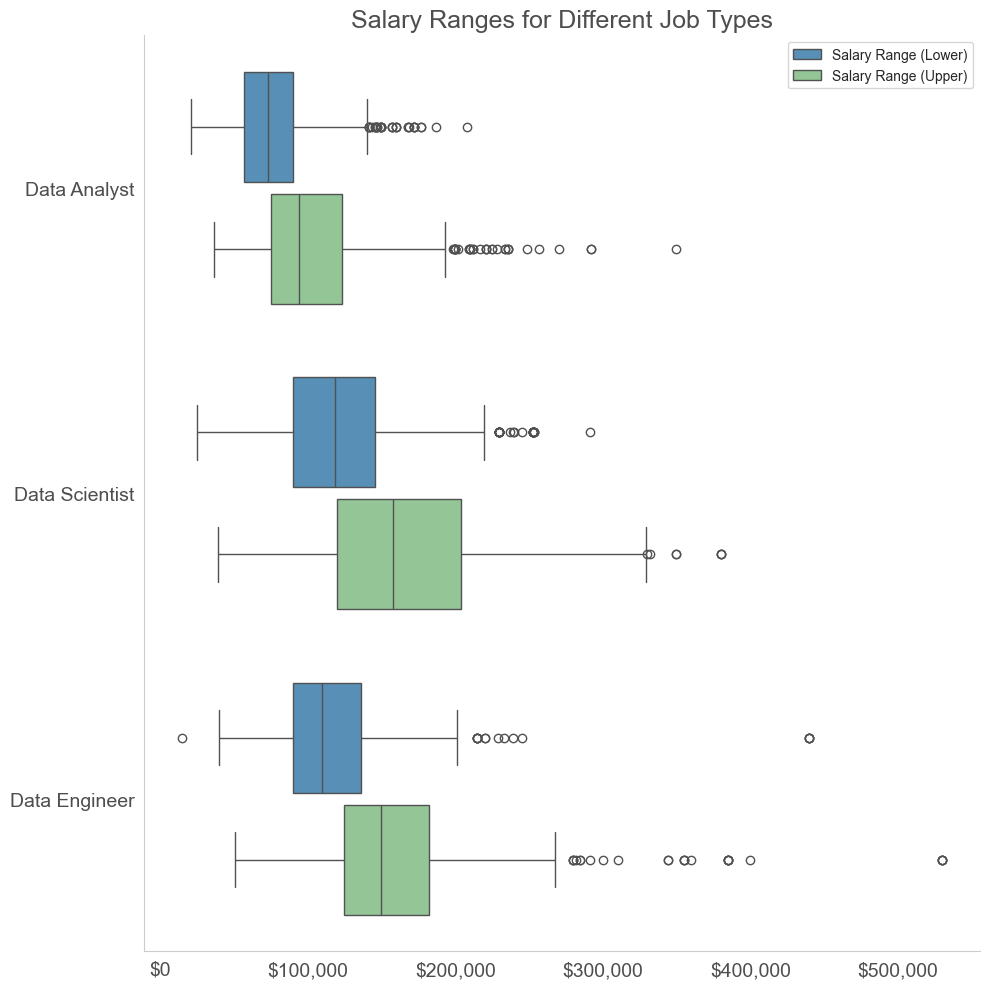

In [23]:
# I took a lot from here: https://github.com/mwaskom/seaborn/issues/720
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_title(f"Salary Ranges for Different Job Types", title_kwargs)
# I can't figure out a good way to incorporate this
# plt.text(x=270_000, y=-0.44, s='Jobs Scraped from $\\bf{Indeed.com}$ and $\\bf{DataJobs.com}$',
#                  color='#4f4e4e', fontsize=14, horizontalalignment='center')

# plot the boxplots
bp = sns.boxplot(
    data=df,
    y="clean_title",
    x="Salary",
    hue="Salary Type",
    ax=ax,
    orient="h",
    palette=[bl, gr],
    gap=0.1,
    order=["Data Analyst", "Data Scientist", "Data Engineer"],
)
sns.despine(top=True, right=True)

ax.grid(False)

ax.set_ylabel("")
ax.set_xlabel("")
plt.yticks(size=14, color=default_font_kwargs["color"])
plt.xticks(size=14, color=default_font_kwargs["color"])

plt.legend(loc="upper right")

# let's fix the x labels to be a little nicer to look a
labels = [item.get_text() for item in ax.get_xticklabels()]
for idx, label in enumerate(labels):
    if label[0] != "−":
        labels[idx] = f"${int(label):,}"

ax.set_xticklabels(labels=labels)
plt.tight_layout()
# plt.savefig("FIGS/salaries.png")

C:\Users\cbrad\AppData\Local\Temp\ipykernel_404\2232125869.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_us_data["state_name"] = temp_us_data["state"].apply(lambda x: state_map[x])
C:\Users\cbrad\AppData\Local\Temp\ipykernel_404\2232125869.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_us_data["avg_salary"] = temp_us_data.apply(lambda x: get_avg_sal(x), axis=1)
C:\Users\cbrad\AppData\Local\Temp\ipykernel_404\2232125869.py:66: UserWarning: set_ticklabels() should only be used with a fi

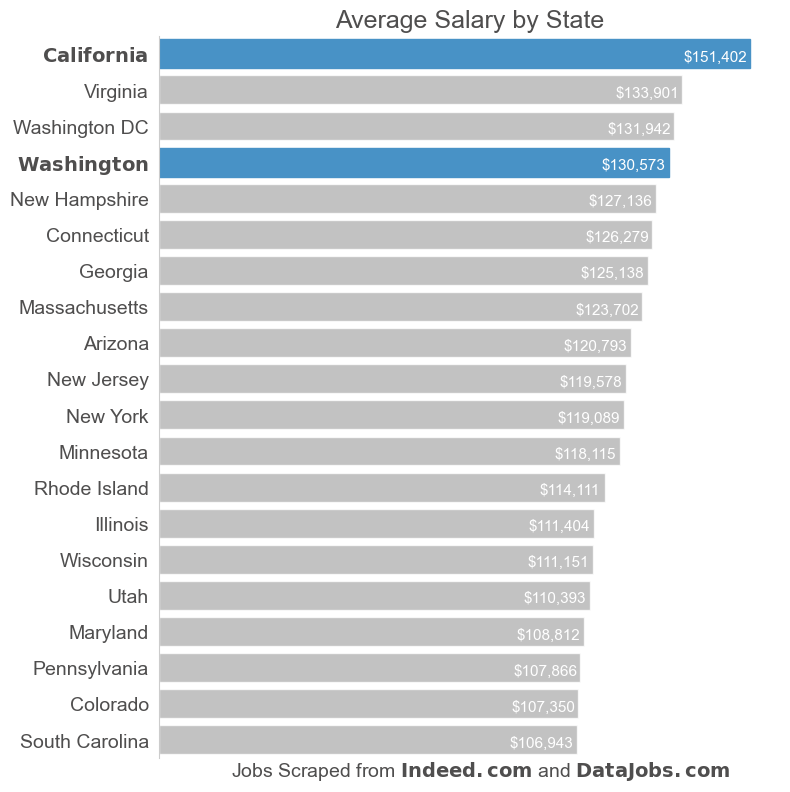

In [27]:
# first, let's get averages of salaries as a function of state
def get_avg_sal(x):
    if pd.isna(x["salary_upper"]):
        return x["salary_lower"]
    else:
        return (x["salary_lower"] + x["salary_upper"]) / 2

# let's dump nan-states
temp_us_data = job_meta[~job_meta['state'].isna()]

# I'd rather see the actual name of the state rather than just the abbreviated state code
temp_us_data["state_name"] = temp_us_data["state"].apply(lambda x: state_map[x])

# get average salaries accross upper/lower
temp_us_data["avg_salary"] = temp_us_data.apply(lambda x: get_avg_sal(x), axis=1)

# get average salaries by state
avg_salary_by_state = (
    temp_us_data[~temp_us_data["state_name"].isna()][["state_name", "avg_salary"]]
    .groupby(["state_name"])
    .mean()
    .sort_values(by = 'avg_salary', ascending=False)
    .to_dict()["avg_salary"]
)


# we only want to check out the top-40 skills
viz_counts = take(n=20, iterable=avg_salary_by_state.items())

f, ax = plt.subplots(figsize=(8, 8))

# plot our counts
sns.barplot(
    y=list(viz_counts.keys()),
    x=list(viz_counts.values()),
    color=lgrey,
    ax=ax,
    orient="h",
)
# minimalism is your friend
sns.despine(bottom=True)

# set titles and subtitles
ax.set_title(f"Average Salary by State", **title_kwargs)
plt.text(
    x=sum(viz_counts.values())/len(viz_counts) - 38000,
    y=20,
    s="Jobs Scraped from $\\bf{Indeed.com}$ and $\\bf{DataJobs.com}$",
    **subtitle_kwargs,
)

plt.yticks(size=14, color=default_font_kwargs["color"])
plt.xticks([], [])

# since I am on the west coast, let's emphasize those states
# loop through the axis labels and bold the west coast states
emph_idx = []
# since I am on the west coast, let's emphasize those states
west_cost = ("California", "Oregon", "Washington")
labels = [item.get_text() for item in ax.get_yticklabels()]
for idx, label in enumerate(labels):
    if label in west_cost:
        labels[idx] = "$\\mathbf{" + label + "}$"
        emph_idx.append(idx)
# set new labels to axis
ax.set_yticklabels(labels=labels)

# grab rectangle objects
childrenLS = ax.get_children()
barlist = list(
    filter(lambda x: isinstance(x, matplotlib.patches.Rectangle), childrenLS)
)
# loop through rectangles and de-emphasize non-west coast states and emphasize west coast states
for idx, bar in enumerate(barlist):
    if idx not in emph_idx:
        bar.set(alpha=0.75)
    else:
        bar.set_color(bl)

# let's label the bars for the west coast states as well.
dlabel_kwargs["fontsize"] = 11
for idx, lbl in enumerate(list(ax.containers[0])):
    h = int(lbl.get_width())
    if h >= 100_000:
        plt.text(y=idx + 0.20, x=int(h) - 9000, s=f"${int(h):,}", **dlabel_kwargs)
    elif h < 100_000:
        plt.text(y=idx + 0.20, x=int(h) - 6000, s=f"${int(h):,}", **dlabel_kwargs)

plt.tight_layout()
# plt.savefig("FIGS/salary_by_state.png")

c:\Users\cbrad\miniconda3\envs\datajobs\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cbrad\AppData\Local\Temp\ipykernel_404\1508296801.py:97: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  hawaii_gdf.clip(hipolygon).plot(


<Axes: >

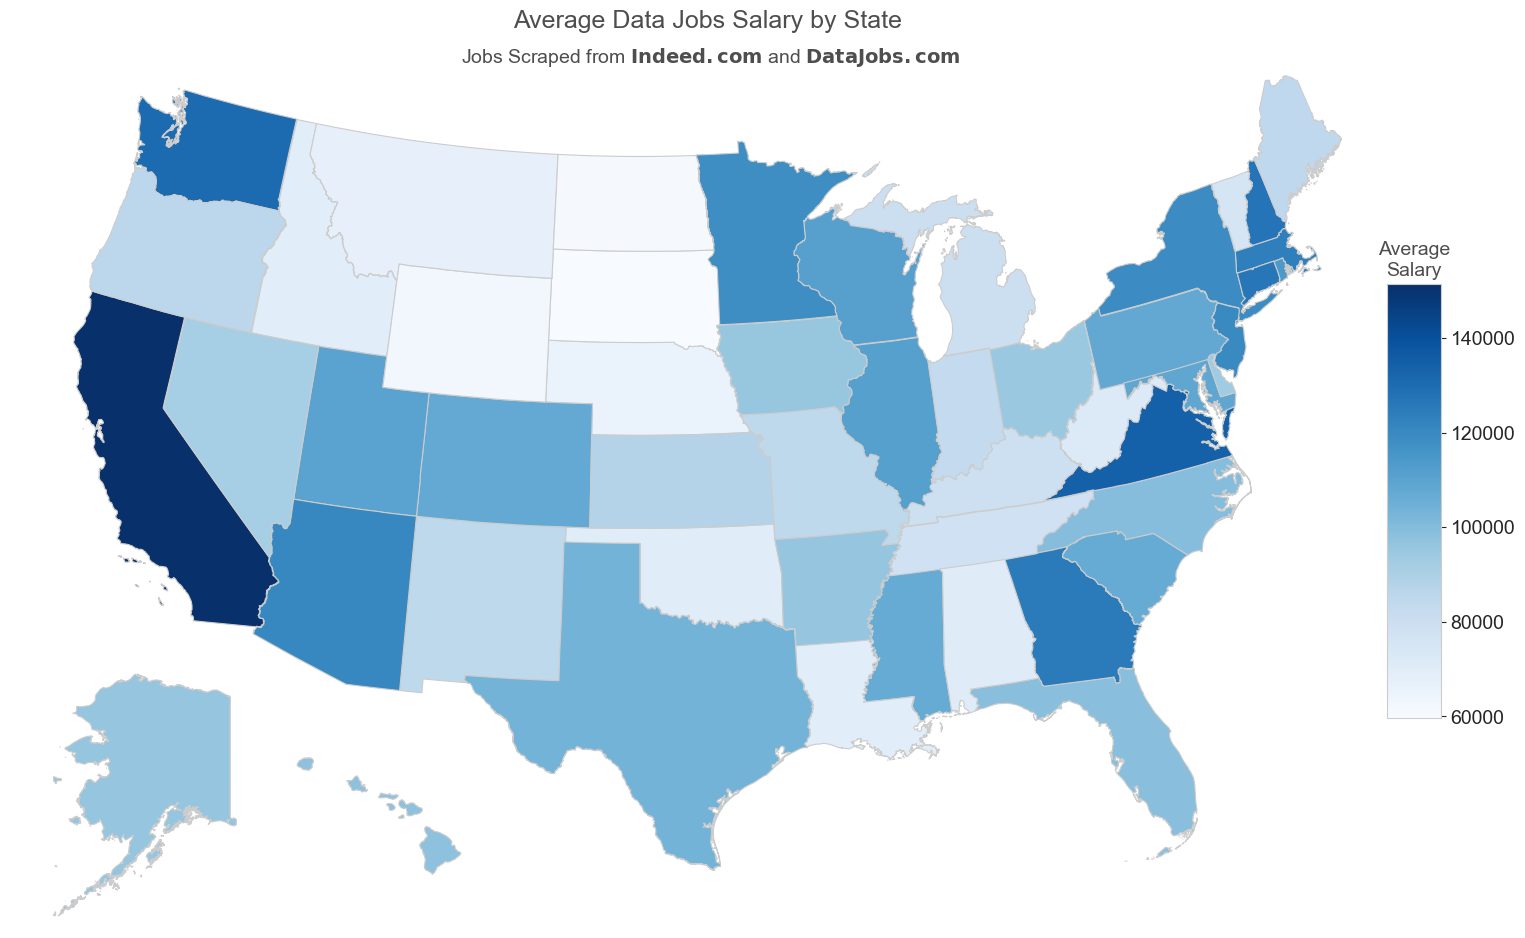

In [28]:
# finally, let's use the same choropleth map from above!
gdf1 = gpd.read_file("./SHAPES/cb_2018_us_state_500k")
# now we can just merge this in with out count data from above
# we want to merge on state code, so we need to add that back
df = pd.DataFrame(avg_salary_by_state.items(), columns = ['state_name', 'avg_salary'])
inv_state_map = {v:k for k,v in state_map.items()}
df['state'] = df["state_name"].apply(lambda x: inv_state_map[x])
gdf = gdf1.merge(df, left_on="STUSPS", right_on="state", how="left")
# there are some non major-50 state codes in here (like Puerto Rico [PR] and Virgin Islands [VI])
gdf = gdf[gdf.STUSPS.isin(state_codes)]

# set the value column that will be visualised
variable = "avg_salary"
state_var = "STUSPS"

# make a column for value_determined_color in gdf
# set the range for the choropleth values with the upper bound the rounded up maximum value
vmin, vmax = gdf[variable].min(), gdf[variable].max()
# this is the color map we have been using (this looks better here than the dark version of the map)
colormap = "Blues"
gdf = makeColorColumn(gdf, variable, vmin, vmax)

# create "visframe" as a re-projected gdf using EPSG 2163 for CONUS
# this is just a specific mapping projection
visframe = gdf.to_crs({"init": "epsg:2163"})

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(18, 14))
# remove the axis box around the vis
ax.axis("off")

# add a title and annotation
ax.set_title("Average Data Jobs Salary by State", **title_kwargs)
ax.annotate(
    "Jobs Scraped from $\\bf{Indeed.com}$ and $\\bf{DataJobs.com}$",
    xy=(0.395, 0.625),
    xycoords="figure fraction",
    **subtitle_kwargs
)

fig = ax.get_figure()
# add colorbar axes to the figure
# This will take some iterating to get it where you want it [l,b,w,h] right
# l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
cbax = fig.add_axes([0.89, 0.32, 0.03, 0.31])

cbax.set_title("Average\nSalary", **subtitle_kwargs)

# add color scale
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# reformat tick labels on legend
sm._A = []
# comma_fmt = FuncFormatter(lambda x, p: format(x/100, '.0%'))
fig.colorbar(sm, cax=cbax)
tick_font_size = 14
cbax.tick_params(labelsize=tick_font_size)

# create map
# Note: we're going state by state here because of unusual coloring behavior when trying to plot the entire dataframe using the "value_determined_color" column
for idx, row in visframe.iterrows():

    if row[state_var] not in ["AK", "HI"]:
        try:
            vf = visframe[visframe[state_var] == row[state_var]]
            c = gdf[gdf[state_var] == row[state_var]][0:1].value_determined_color.item()
        except:
            print(
                vf,
                gdf[gdf[state_var] == row[state_var]][0:1][
                    ["STUSPS", "value_determined_color"]
                ],
                sep="\n" * 2,
            )
        else:
            vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor="0.8")

# add Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])
akax.axis("off")
# polygon to clip western islands
polygon = Polygon([(-170, 50), (-170, 72), (-140, 72), (-140, 50)])
alaska_gdf = gdf[gdf[state_var] == "AK"]
alaska_gdf.clip(polygon).plot(
    color=gdf[gdf[state_var] == "AK"].value_determined_color,
    linewidth=0.8,
    ax=akax,
    edgecolor="0.8",
)


# add Hawaii
hiax = fig.add_axes([0.28, 0.20, 0.1, 0.1])
hiax.axis("off")
# polygon to clip western islands
hipolygon = Polygon([(-160, 0), (-160, 90), (-120, 90), (-120, 0)])
hawaii_gdf = gdf[gdf[state_var] == "HI"]
hawaii_gdf.clip(hipolygon).plot(
    column=variable,
    color=hawaii_gdf["value_determined_color"].values[0],
    linewidth=0.8,
    ax=hiax,
    edgecolor="0.8",
)
# plt.tight_layout()
# plt.savefig("FIGS/salary_chloropleth.png", dpi=fig.dpi)

In [29]:
ca_da_sal = temp_us_data[(temp_us_data["state"] == "CA") & (temp_us_data["clean_title"] == "Data Analyst")]['avg_salary'].mean()
ca_ds_sal = temp_us_data[(temp_us_data["state"] == "CA") & (temp_us_data["clean_title"] == "Data Scientist")]['avg_salary'].mean()
ca_de_sal = temp_us_data[(temp_us_data["state"] == "CA") & (temp_us_data["clean_title"] == "Data Engineer")]['avg_salary'].mean()
print(f"In California, the mean salary for a Data Analyst is: ${ca_da_sal:,.2f}, a Data Engineer: ${ca_de_sal:,.2f}, a Data Scientist: ${ca_ds_sal:,.2f}.")

ca_da_sal_m = temp_us_data[(temp_us_data["state"] == "CA") & (temp_us_data["clean_title"] == "Data Analyst")]['avg_salary'].median()
ca_ds_sal_m = temp_us_data[(temp_us_data["state"] == "CA") & (temp_us_data["clean_title"] == "Data Scientist")]['avg_salary'].median()
ca_de_sal_m = temp_us_data[(temp_us_data["state"] == "CA") & (temp_us_data["clean_title"] == "Data Engineer")]['avg_salary'].median()
print(f"In California, the median salary for a Data Analyst is: ${ca_da_sal_m:,.2f}, a Data Engineer: ${ca_de_sal_m:,.2f}, a Data Scientist: ${ca_ds_sal_m:,.2f}.")

In California, the mean salary for a Data Analyst is: $101,779.83, a Data Engineer: $168,176.41, a Data Scientist: $181,514.61.
In California, the median salary for a Data Analyst is: $94,900.00, a Data Engineer: $150,000.00, a Data Scientist: $180,050.00.


In [30]:
va_da_sal = temp_us_data[(temp_us_data["state"] == "VA") & (temp_us_data["clean_title"] == "Data Analyst")]['avg_salary'].mean()
va_ds_sal = temp_us_data[(temp_us_data["state"] == "VA") & (temp_us_data["clean_title"] == "Data Scientist")]['avg_salary'].mean()
va_de_sal = temp_us_data[(temp_us_data["state"] == "VA") & (temp_us_data["clean_title"] == "Data Engineer")]['avg_salary'].mean()
print(f"In Virginia, the mean salary for a Data Analyst is: ${va_da_sal:,.2f}, a Data Engineer: ${va_de_sal:,.2f}, a Data Scientist: ${va_ds_sal:,.2f}.")

va_da_sal_m = temp_us_data[(temp_us_data["state"] == "VA") & (temp_us_data["clean_title"] == "Data Analyst")]['avg_salary'].median()
va_ds_sal_m = temp_us_data[(temp_us_data["state"] == "VA") & (temp_us_data["clean_title"] == "Data Scientist")]['avg_salary'].median()
va_de_sal_m = temp_us_data[(temp_us_data["state"] == "VA") & (temp_us_data["clean_title"] == "Data Engineer")]['avg_salary'].median()
print(f"In Virginia, the median salary for a Data Analyst is: ${va_da_sal_m:,.2f}, a Data Engineer: ${va_de_sal_m:,.2f}, a Data Scientist: ${va_ds_sal_m:,.2f}.")

In Virginia, the mean salary for a Data Analyst is: $88,140.74, a Data Engineer: $143,648.52, a Data Scientist: $179,828.25.
In Virginia, the median salary for a Data Analyst is: $95,000.00, a Data Engineer: $135,000.00, a Data Scientist: $173,275.00.


In [31]:
# these salaries look a little high. let's check out some of the larger ones
temp_us_data[(temp_us_data["avg_salary"] > 150_000) & (temp_us_data["clean_title"] == "Data Scientist")]

,url,title,company,location,salary_lower,salary_upper,job_category,site,job_id,pull_date,state,clean_title,state_name,avg_salary
16,https://www.indeed.com/viewjob?jk=4c2c23ba0a6d...,Data Scientist,NaN,"Cupertino, CA",138900.0,256500.0,Data Scientist,https://indeed.com/,3547,04/08/2024,CA,Data Scientist,California,197700.0
137,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Senior Data Scientist,The Hollister Group,"Boston, MA 02215",180000.0,NaN,Data Scientist,https://indeed.com/,3668,04/08/2024,MA,Data Scientist,Massachusetts,180000.0
143,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"Senior Data Scientist, Product and Insights","GTT, LLC","Newark, NJ 07102",236891.2,NaN,Data Scientist,https://indeed.com/,3674,04/08/2024,NJ,Data Scientist,New Jersey,236891.2
149,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Senior Data Scientist / PhD preferred,Motion Recruitment,"Irvine, CA",160000.0,170000.0,Data Scientist,https://indeed.com/,3680,04/08/2024,CA,Data Scientist,California,165000.0
154,https://www.indeed.com/viewjob?jk=c87099f23f14...,Data Scientist II,Pinterest,"San Francisco, CA",119273.0,209296.0,Data Scientist,https://indeed.com/,3685,04/08/2024,CA,Data Scientist,California,164284.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3874,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Principal Data Scientist,Jennings Executive Search,"Duluth, GA 30096",175000.0,240000.0,Data Scientist,https://indeed.com/,7405,04/17/2024,GA,Data Scientist,Georgia,207500.0
5726,https://www.indeed.com/viewjob?jk=72eb7cb62bd2...,HID Health User Studies Data Science Engineer,Apple,"Cupertino, CA",132300.0,241500.0,Data Engineer,https://indeed.com/,9257,04/17/2024,CA,Data Scientist,California,186900.0
5728,https://www.indeed.com/viewjob?jk=72eb7cb62bd2...,HID Health User Studies Data Science Engineer,Apple,"Cupertino, CA",132300.0,241500.0,Data Engineer,https://indeed.com/,9259,04/17/2024,CA,Data Scientist,California,186900.0
5763,https://www.indeed.com/viewjob?jk=916cf998a960...,Machine Learning Engineer/ Data Scientist,Adobe,"San Jose, CA 95110",135200.0,250900.0,Data Engineer,https://indeed.com/,9294,04/17/2024,CA,Data Scientist,California,193050.0


# 🎲 **Step 4**: Are the Salaries actually different?

Let's do some tests to find out if the salaries for these different position types are actually different.

1) Is my data noramlly distributed? Or at least close? Chi squared test and QQ-plot
2) Are outliers affecting my means?
3) t-tests to see if salaries are significantly differnet. 

Some links to check out:
1) https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
2) https://zachary-a-zazueta.medium.com/parametric-vs-non-parametric-statistical-tests-in-python-9c7ab48e954a#:~:text=Parametric%20tests%20will%20compare%20group,the%20data%20can%20matter%20significantly.

### Histograms

To get a feel for the distributions of the salary info, let's plot some density plots/histograms. Remember that there are two salary entries for the range of salaries. 

NameError: name 'df' is not defined

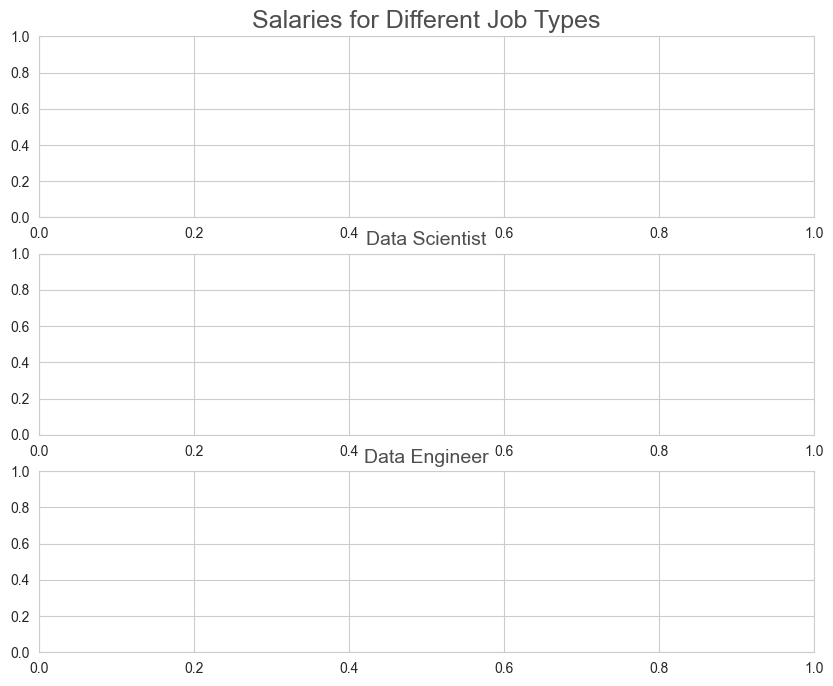

In [ ]:
# is the data normally distributed? This is important for a t-test
# let's first just look at histograms

fig, ax = plt.subplots(3,1,figsize=(10, 8))

ax[0].set_title(f"Salaries for Different Job Types", **title_kwargs)
ax[0].annotate(
    "Data Analyst",
    xy=(0.515, 0.87),
    xycoords="figure fraction",
    **subtitle_kwargs
)

ax[1].set_title(f"Data Scientist", **subtitle_kwargs)

ax[2].set_title(f"Data Engineer", **subtitle_kwargs)
# I can't figure out a good way to incorporate this
# plt.text(x=270_000, y=-0.44, s='Jobs Scraped from $\\bf{Indeed.com}$ and $\\bf{DataJobs.com}$',
#                  color='#4f4e4e', fontsize=14, horizontalalignment='center')

# plot the boxplots

hp1 = sns.histplot(
    data=df[df['clean_title'] == 'Data Analyst'],
    # x="clean_title",
    x="Salary",
    hue="Salary Type",
    ax=ax[0],
    palette=[bl, gr],
    kde=True
)

hp2 = sns.histplot(
    data=df[df['clean_title'] == 'Data Scientist'],
    # x="clean_title",
    x="Salary",
    hue="Salary Type",
    ax=ax[1],
    palette=[bl, gr],
    kde=True
)

hp3 = sns.histplot(
    data=df[df['clean_title'] == 'Data Engineer'],
    # x="clean_title",
    x="Salary",
    hue="Salary Type",
    ax=ax[2],
    palette=[bl, gr],
    kde=True
)

sns.despine(top=True, right=True)

for idx, axis in enumerate(ax):
    axis.grid(False)
    axis.set_ylabel("")
    axis.set_xlabel("")
    axis.set_yticklabels(axis.get_yticklabels(), size=14, color=default_font_kwargs["color"])
    axis.legend().set_visible(False)
    # let's fix the x labels to be a little nicer to look a
    labels = [item.get_text() for item in axis.get_xticklabels()]
    for idx, label in enumerate(labels):
        if label[0] != "−":
            labels[idx] = f"${int(label):,}"

    axis.set_xticklabels(labels=labels,size=14, color=default_font_kwargs["color"])


# fig.legend([hp1, hp2, hp3], labels=labels, 
#            loc="upper right") 
# plt.setp(ax, xlim=(0,500_000), ylim=(0,100))
plt.tight_layout()

# plt.savefig("FIGS/salaries.png")

### QQ-Plots

In [ ]:
# These do look a little fat tailed. Let's check QQ plots
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
fig, ax = plt.subplots(2,3,figsize=(20,8))

# q-q plot
qqplot(data=df[(df['clean_title'] == 'Data Analyst') & (df['Salary Type'] == 'Salary Range (Upper)')]['Salary'].values, line='s', ax=ax[0,0], markerfacecolor = gr, markeredgecolor=gr, alpha = 0.3)
qqplot(data=df[(df['clean_title'] == 'Data Analyst') & (df['Salary Type'] == 'Salary Range (Lower)')]['Salary'].values, line='s', ax=ax[1,0], markerfacecolor = bl, markeredgecolor=bl, alpha = 0.3)

qqplot(data=df[(df['clean_title'] == 'Data Scientist') & (df['Salary Type'] == 'Salary Range (Upper)')]['Salary'].values, line='s', ax=ax[0,1], markerfacecolor = gr, markeredgecolor=gr, alpha = 0.3)
qqplot(data=df[(df['clean_title'] == 'Data Scientist') & (df['Salary Type'] == 'Salary Range (Lower)')]['Salary'].values, line='s', ax=ax[1,1], markerfacecolor = bl, markeredgecolor=bl, alpha = 0.3)

qqplot(data=df[(df['clean_title'] == 'Data Engineer') & (df['Salary Type'] == 'Salary Range (Upper)')]['Salary'].values, line='s', ax=ax[0,2], markerfacecolor = gr, markeredgecolor=gr, alpha = 0.3)
qqplot(data=df[(df['clean_title'] == 'Data Engineer') & (df['Salary Type'] == 'Salary Range (Lower)')]['Salary'].values, line='s', ax=ax[1,2], markerfacecolor = bl, markeredgecolor=bl, alpha = 0.3)


for axis in ax.flatten():
    axis.get_lines()[1].set(color="black", linewidth = "1.5", alpha = 0.5, linestyle = "--")

ax[0,0].set_title(f"\nData Analyst", **subtitle_kwargs)

ax[0,1].annotate("QQ-Plots for Different Job Types",
    xy=(0.435, 0.87),
    xycoords="figure fraction",
    **title_kwargs)
ax[0,1].set_title(f"\nData Scientist", **subtitle_kwargs)

ax[0,2].set_title(f"\nData Engineer", **subtitle_kwargs)

plt.show()

In [ ]:
# so Mostly normal with some fuzziness at the ends due to outliers/lack of data. That's ok! The students T-test is pretty robust to non-normality
# how about the formal tests?
# the Shapiro Wilk test is great for low sample sizes!
from scipy.stats import shapiro

titles = [
    'Data Scientist',
    'Data Engineer',
    'Data Analyst'
]

salary_buckets = [
    'Salary Range (Upper)',
    'Salary Range (Lower)'
]

for t in titles:
    for sb in salary_buckets:
        tdf = df[(df['clean_title'] == t) & (df['Salary Type'] == sb)]['Salary'].values
        # print(tdf[:5])
        stat, p = shapiro(tdf)
        
        print(f'Job Title: {t}, Salary Bucket: {sb}\n\t- Statistic={stat:.3f}, p={p:.5f}')

        # interpret
        alpha = 0.05
        if p > alpha:
            print('\t- Sample looks Normal')
        else:
            print('\t- Sample does not look Normal')

In [ ]:
# we should have expected this with the outliers. I wonder if we gather more data if the low end will be fixed. And if we restrict outliers if that will fix the high end. Outliers we can do now

# we can try limiting outliers now
for t in titles:
    for sb in salary_buckets:
        if t == 'Data Analyst':
            tdf = df[(df['clean_title'] == t) & (df['Salary Type'] == sb) & (df['Salary'] <= 200_000)]['Salary'].values
        else:
            tdf = df[(df['clean_title'] == t) & (df['Salary Type'] == sb) & (df['Salary'] <= 250_000)]['Salary'].values
        # print(tdf[:5])
        stat, p = shapiro(tdf)
        
        print(f'Job Title: {t}, Salary Bucket: {sb}\n\t- Statistic={stat:.3f}, p={p:.5f}')

        # interpret
        alpha = 0.05
        if p > alpha:
            print('\t- Sample looks Normal')
        else:
            print('\t- Sample does not look Normal')

In [ ]:
# clearly the outliers aren't the issue. Let's try the t-test and non-parametric tests to see if we get different answers.
# since we are comparing two population means, we want to use the Unpaired t-test or the Mann Whitney U test
from scipy.stats import ttest_ind, ranksums

stats = []

for sb in salary_buckets:
    ds = df[(df['clean_title'] == 'Data Scientist') & (df['Salary Type'] == sb)]['Salary'].values
    de = df[(df['clean_title'] == 'Data Engineer') & (df['Salary Type'] == sb)]['Salary'].values
    da = df[(df['clean_title'] == 'Data Analyst') & (df['Salary Type'] == sb)]['Salary'].values

    ds_da_tt_res = ttest_ind(ds, da, equal_var = False, alternative = 'greater')
    de_ds_tt_res = ttest_ind(de, ds, equal_var = False, alternative = 'greater')
    de_da_tt_res = ttest_ind(de, da, equal_var = False, alternative = 'greater')

    ds_da_rs_res = ranksums(ds, da, alternative = 'greater')
    de_ds_rs_res = ranksums(de, ds, alternative = 'greater')
    de_da_rs_res = ranksums(de, da, alternative = 'greater')

    stats += [
        {
            'Salary Bucket': sb,
            'Compared Jobs': 'DS vs. DA',
            'Test':'T-test',
            'Statistic':ds_da_tt_res.statistic,
            'p_value':round(ds_da_tt_res.pvalue, 3)
        },
        {
            'Salary Bucket': sb,
            'Compared Jobs': 'DS vs. DA',
            'Test':'Rank Sums',
            'Statistic':ds_da_rs_res.statistic,
            'p_value':round(ds_da_rs_res.pvalue, 3)
        },
        {
            'Salary Bucket': sb,
            'Compared Jobs': 'DE vs. DS',
            'Test':'T-test',
            'Statistic':de_ds_tt_res.statistic,
            'p_value':round(de_ds_tt_res.pvalue, 3)
        },
        {
            'Salary Bucket': sb,
            'Compared Jobs': 'DE vs. DS',
            'Test':'Rank Sums',
            'Statistic':de_ds_rs_res.statistic,
            'p_value':round(de_ds_rs_res.pvalue, 3)
        },
        {
            'Salary Bucket': sb,
            'Compared Jobs': 'DE vs. DA',
            'Test':'T-test',
            'Statistic':de_da_tt_res.statistic,
            'p_value':round(de_da_tt_res.pvalue, 3)
        },
        {
            'Salary Bucket': sb,
            'Compared Jobs': 'DE vs. DA',
            'Test':'Rank Sums',
            'Statistic':de_da_rs_res.statistic,
            'p_value':round(de_da_rs_res.pvalue, 3)
        },
    ]

salary_stats_df = pd.DataFrame(stats)
alpha = 0.05
salary_stats_df['Hypothesis Test'] = salary_stats_df['p_value'].apply(lambda x: False if x > alpha else True)
salary_stats_df

This is exactly what we expected from looking at our box plots! It is true that Data Scientists and Data Engineers make more than Data Analysts on average; however, there is not much of a distinction in Data Engineer and Data Scientist pay. 

# Conclusions

What have we learned from this analysis? Well, for starters, [Indeed](https://indeed.com/) certainly has _many_ more jobs posted on it than [DataJobs](https://datajobs.com/) does. Secondly, I'm in a good spot on the west coast! Many of the jobs I scraped are on the west coast of the United States. As for the top skills, there are some standard ones:
1) Python
2) Machine Learning
3) AWS, Azure and GCP
4) R

But there are also some surprises:

1) Forecasting
2) Qlik
3) SAS
4) Scala

Soft skills, while not focused on by many interested in the field, are _very_ important in employers eyes. And, while Data Scientists and Data Engineers have similar salary ranges, there seem to be more Data Engineer jobs available.

# Resources
I am not the first person to do this! Please check out some other folks' work I've compiled below:

1) [Finding where I stand in the Data Science world by web scraping job openings.
](https://towardsdatascience.com/gone-to-find-myself-finding-where-i-am-in-the-data-science-world-by-web-scraping-job-postings-bf416dbfb6fa)
2) [Web Scraping Indeed.com](https://towardsdatascience.com/web-scraping-indeed-com-e5591790736d)
3) [The Most In-Demand Skills for Data Scientists in 2021](https://towardsdatascience.com/the-most-in-demand-skills-for-data-scientists-in-2021-4b2a808f4005)
4) [Web scraping 2023 data science jobs on Indeed to extract the key skills required](https://medium.com/@alex.kirkup/web-scraping-2023-data-science-jobs-listings-to-extract-the-key-skills-required-2359bfab176e)
